## Data

In [8]:
from notebooks.text_processing import generate_corpus_df, add_sectarian_label, convert_df_to_by_book
import pandas as pd
import numpy as np
from notebooks.utils import generate_composition_to_book
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
RERUN = False

## Topic modeling

In [9]:
#Pre processing in EDA notebook
df_by_book = pd.read_csv('data/full_data_nonbib_01_05_24.csv')

In [10]:
from gensim import corpora
def generate_componentes_for_gensim(df, relevant_col):
    """
    df: each row is a text
    relevant_col: which col is the text
    """
    
    texts = [
    [word for word in str(doc).split(" ")]
    for doc in df[relevant_col]]
    id2word = corpora.Dictionary(texts)
    corpus = [id2word.doc2bow(text) for text in texts]
    print(f"Doc num: {len(corpus)}, vocab len: {len(id2word)}")
    return texts, id2word, corpus


In [11]:
# from gensim import corpora
# texts, id2word, corpus = generate_componentes_for_gensim(df_by_book, "processed_text")
# texts_lem, id2word_lem, corpus_lem = generate_componentes_for_gensim(df_by_book, "lemmatized_text")
# list(zip(texts[0][:20],texts_lem[0][:10]))

### Choosing the right number of topics

When performing topic modeling with LDA, one of the parameters that we need to provide is the number of topics we wish to get as the result.
This problem is a bit challenging because of the following reasons:
1. Subjective Interpretations: The determination of what constitutes a coherent topic is subjective and varies between users. This variability makes it difficult to establish a universally optimal number of topics that satisfy all interpretations and use cases.
[Reading Tea Leaves: How Humans Interpret Topic Models](https://proceedings.neurips.cc/paper/2009/file/f92586a25bb3145facd64ab20fd554ff-Paper.pdf).

2. Corpus Characteristics: The diversity and dimensions of the dataset—such as document length, the breadth of vocabulary, and the granularity of content—play a critical role in influencing the appropriate number of topics. Different corpora may naturally support different numbers of distinct themes.
Reference: Greene, D., O'Callaghan, D., & Cunningham, P. (2014). [How Many Topics? Stability Analysis for Topic Models](https://arxiv.org/pdf/1404.4606)

3. Absence of Ground Truth: In unsupervised learning, like topic modeling, there is no clear benchmark or ground truth for validating the chosen number of topics. This absence makes it challenging to objectively evaluate the accuracy and relevance of the model's output.
Reference: [On finding the natural number of topics with latent dirichlet allocation: Some observations](https://link.springer.com/chapter/10.1007/978-3-642-13657-3_43)


4. Sensitivity to Model Specifications: The chosen number of topics can be sensitive to slight variations in model parameters or the data preprocessing steps. This sensitivity often results in different models suggesting different numbers of topics for the same dataset, complicating the selection process.
Reference: Lau, J. H., Newman, D., & Baldwin, T. (2014). [Machine reading tea leaves: Automatically evaluating topic coherence and topic model quality](https://aclanthology.org/E14-1056/)




As for today, the main metrics for choosing the number of topics are:

1. Coherence Measures: Coherence scores, such as C_V, UMass, C_UCI, and C_NPMI, are widely used because they offer a quantitative way to assess the semantic coherence of the topics produced by the model. These measures evaluate how meaningfully the top words in each topic relate to each other, with higher scores generally indicating better topics. (I will explain more in depth below)
Reference: Röder, M., Both, A., & Hinneburg, A. (2015). Exploring the space of topic coherence measures. In WSDM.

2. Perplexity: Perplexity is a statistical measure of how well a probability model predicts a sample. In topic modeling, lower perplexity is typically associated with a model that can better predict unseen documents, although it does not necessarily correlate with human interpretability of the topics.
Reference: Blei, D. M., Ng, A. Y., & Jordan, M. I. (2003). Latent dirichlet allocation. Journal of Machine Learning Research.

$$
\text{perplexity}({D_{test}}) = \exp\left\{-\frac{\sum_{d=1}^{M} \log p(w_d)}{\sum_{d=1}^{M} N_d}\right\}
$$


3. Stability Analysis: Stability analysis involves measuring how consistent the topics are across different runs of the model, with varying parameters or subsamples of the data. Consistent topics across multiple tests can indicate that the model has found a meaningful structure in the data.
Reference: Mimno, D., Wallach, H. M., Talley, E., Leenders, M., & McCallum, A. (2011). Optimizing semantic coherence in topic models. In EMNLP.

4. Human Judgment: Ultimately, qualitative evaluation by subject matter experts is often used in conjunction with quantitative methods. Experts assess the meaningfulness and utility of the topics within the context of specific research or business objectives.
Reference: Chang, J., Boyd-Graber, J., Gerrish, S., Wang, C., & Blei, D. M. (2009). Reading Tea Leaves: How Humans Interpret Topic Models. In NeurIPS.

5. Elbow Method: Similar to its use in other domains like cluster analysis, the elbow method involves plotting a metric like coherence or perplexity against the number of topics and looking for a "knee" in the curve. This knee, or elbow point, is considered an indicator of the optimal number of topics.
Reference: Kulkarni, V., Kern, M. L., Stillwell, D., & Kosinski, M. (2021). Latent Dirichlet Allocation with K-means++ Initialization. Insights.

There are also a few papers that tried to use some new metrics (combining a few metrics together) like in [Selection of the Optimal Number of Topics for LDA Topic Model—Taking Patent Policy Analysis as an Example](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8534395/), [A heuristic approach to determine an appropriate number of topics in topic modeling](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-16-S13-S8) 



### UCI Coherence Measure
Coherence measures in topic modeling are crucial for evaluating the quality of the topics extracted by models such as LDA. They help determine how meaningful and interpretable the topics are. I will give a short overview of four common types of coherence measures: `u_mass`, `c_v`, `c_uci`, and `c_npmi`, including their formulas and whether higher or lower values are better.

[Exploring the Space of Topic Coherence Measures](https://dl.acm.org/doi/10.1145/2684822.2685324)

1. UCI is the first coherence measure developed by Newman et al. (2010). This measure calculates the coherence by using the top $N$ words from each topic. The UCI coherence is defined as follows:

$$
\text{UCI} = \frac{2}{N \cdot (N-1)} \sum_{i=1}^{N-1} \sum_{j=i+1}^{N} \text{PMI}(w_i, w_j)
$$

Where:
- $N$ is the number of top words chosen for each topic.
- PMI($w_i, w_j$) represents the pointwise mutual information between words $ w_i $ and $ w_j $, calculated as:
  $$
  \text{PMI}(w_i, w_j) = \log \frac{P(w_i, w_j) + \epsilon}{P(w_i) \cdot P(w_j)}
  $$

- $ P(w_i, w_j) $ is the probability of observing words $ w_i $ and $ w_j $ co-occurring within a certain sliding window through the corpus.
- $ P(w_i) $ and $ P(w_j) $ are the probabilities of observing each word independently as the window slides through the corpus.
- $ \epsilon $ is a smoothing factor added to avoid taking a logarithm of zero. The original UCI measure sets $ \epsilon = 1 $.

UCI is essentially the average PMI of the top $ N $ words in each topic. As words co-occur more frequently within the specified context window, their PMI, and thus the UCI score, increases. This measure evaluates how semantically coherent the top words in a topic are, based on their co-occurrence in an external corpus.


2. UMass, developed by Mimno et al. (2011), computes the co-occurrence between pairs of words using only the model's training documents, unlike UCI which uses an external corpus. The UMass coherence measure is defined as follows:

$$
\text{UMass} = \frac{2}{N \cdot (N-1)} \sum_{i=1}^{N} \sum_{j=1}^{i-1} \log \frac{P(w_i, w_j) + \epsilon}{P(w_j)}
$$

Where:
- $ N $ is the number of top words selected from each topic.
- $ P(w_j) $ is the probability of observing word $ w_j $, calculated by counting how many documents contain the word $ w_j $.
- $ P(w_i, w_j) $ is the probability of observing words $ w_i $ and $ w_j $ co-occurring in the same documents, based on the count of documents that contain both words.
- $ \epsilon $ is a smoothing factor added to avoid taking a logarithm of zero, typically set to 1 in the original formulation.

While the formulas for UCI and UMass might look similar, their calculations differ significantly. UMass specifically looks for co-occurrence within the documents of the training corpus, focusing on document co-occurrence rather than sliding window co-occurrence. This measure calculates the average logarithmic document co-occurrence for each topic, and an increase in co-occurrence leads to a higher UMass score.

3. NPMI (Normalized Pointwise Mutual Information), introduced by Aletras and Stevenson (2013), modifies the traditional PMI (Pointwise Mutual Information) used in coherence measures like UCI by normalizing it. The normalization of PMI helps rescale the probabilities of word co-occurrence, which is defined as follows:

$$
\text{NPMI}(w_i, w_j) = \frac{\log \frac{P(w_i, w_j) + \epsilon}{P(w_i) \cdot P(w_j)}}{-\log (P(w_i, w_j) + \epsilon)}
$$

Where:
- $ P(w_i, w_j) $ is the probability of observing words $ w_i $ and $ w_j $ co-occurring within a specified context.
- $ P(w_i) $ and $ P(w_j) $ are the probabilities of observing each word independently.
- $ \epsilon $ is a smoothing factor, typically added to ensure the logarithm is not computed for zero.

This measure applies a negative logarithm to the co-occurrence probability of each word pair to normalize the results, making NPMI a ratio that ranges from -1 to 1. Studies such as those by Aletras and Stevenson (2013) and later by Lau et al. (2014) found that NPMI performed better and correlated more closely with human judgment compared to UCI. In practice, NPMI scores for all top word pairs in a topic are averaged to produce the final coherence score for that topic.

4. C_V Coherence Measure

Developed by Röder et al. (2015), the C_V coherence measure emerges from a comprehensive framework designed to enhance coherence calculations. This framework led to the development of several new coherence measures, with C_V being particularly noteworthy for its high correlation with human evaluations.

Unlike traditional coherence measures that rely on co-occurrence frequencies, C_V uses context vectors. These vectors count the occurrences of words within a window of ± five tokens from each top word but restricts this count to the topic's top words. This ensures that all vectors are uniform in length and composition.

For instance, if the top words in a topic are "game, sport, team," the context vector for "game" would be computed as follows:
$$
\vec{v}_{\text{game}} = [\text{NPMI}(\text{game, game}), \text{NPMI}(\text{game, sport}), \text{NPMI}(\text{game, team})]
$$

After constructing the context vectors, C_V computes the cosine similarity between them to gauge coherence:
$$
\text{cos}(\vec{u}, \vec{w}) = \frac{\sum_{i=1}^{|W|} u_i \cdot w_i}{\|\vec{u}\|^2 \cdot \|\vec{w}\|^2}
$$
where $ \vec{u} $ and $ \vec{w} $ are the context vectors being compared, and $ W $ represents all top word context vectors.

The key innovation of C_V is its focus on indirect semantic similarities rather than direct co-occurrences, allowing it to capture semantic relationships that are not evident through simple co-occurrence.


In the article [Exploring the Space of Topic Coherence Measures](https://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf) the researchers showed that the CV method is mostly correlated with human judgments.




<!---
mostly taken from https://fse.studenttheses.ub.rug.nl/28618/1/s2863685_alfiuddin_hadiat_CCS_thesis.pdf
-->

In [12]:
import gensim
from collections import Counter
from gensim import corpora
from sklearn.model_selection import train_test_split

# Functions related to word frequency analysis
def get_top_n_words(texts, n):
    word_counts = Counter([word for text in texts for word in text])
    return [word[0] for word in word_counts.most_common(n)]

def get_bottom_n_words(texts, n):
    word_counts = Counter([word for text in texts for word in text])
    return [word[0] for word in word_counts.most_common()[:-n-1:-1]]

def remove_words_from_text(texts, words_to_remove):
    new_texts = []
    for text in texts:
        new_texts.append([word for word in text if word not in words_to_remove])
    return new_texts

# Text preprocessing and transformation
def pre_processing_bigram_common_words(texts, min_count_bigram, threshold_bigram, top_words_removal, bottom_words_removal):
    bigram = gensim.models.Phrases(texts, min_count=min_count_bigram, threshold=threshold_bigram)
    texts = [bigram[text] for text in texts]

    most_common_words = get_top_n_words(texts, top_words_removal)
    texts = remove_words_from_text(texts, most_common_words)
    least_common_words = get_bottom_n_words(texts, bottom_words_removal)
    texts = remove_words_from_text(texts, least_common_words)

    print(f"Removed {most_common_words}, {least_common_words} from text")
    return texts

def generate_components(column, random_state, min_count_bigram, threshold_bigram, top_words_removal, bottom_words_removal):
    # train_texts, test_texts = train_test_split(
    #     [[word for word in str(doc).split(" ")] for doc in df_by_book[column]],
    #     test_size=test_size, random_state=random_state
    # )
    texts = [[word for word in str(doc).split(" ")] for doc in df_by_book[column]]
    
    texts = pre_processing_bigram_common_words(texts, min_count_bigram, threshold_bigram, top_words_removal, bottom_words_removal)
    
    # Building corpora and dictionaries for train and test sets
    id2word = corpora.Dictionary(texts)
    corpus = [id2word.doc2bow(text) for text in texts]
    
    return (texts, id2word, corpus)



The main packages for doing topic modeling in python today are [Gensim](https://radimrehurek.com/gensim/), [scikit-learn](https://scikit-learn.org/) and [tomotopy](https://bab2min.github.io/tomotopy/v0.12.6/en/).
Tomotopy is the fastest (written in C) and the most maintainable for today, so i choose to use that.

Here i ran multiple metrics on a different number of metrics with the LDA model.

In [13]:
import tomotopy as tp
import pandas as pd
from scipy.spatial import distance
from datetime import datetime

def compute_perplexity(lda_model):
    """ Computes the perplexity of the LDA model """
    return lda_model.perplexity

def js_divergence(model):
    """ Computes the Jensen-Shannon divergence between topic distributions """
    topic_probs = [model.get_topic_word_dist(k) for k in range(model.k)]
    avg_probs = np.mean(topic_probs, axis=0)
    js_divs = []
    for probs in topic_probs:
        js_div = distance.jensenshannon(probs, avg_probs, base=2)
        js_divs.append(js_div)
    return np.mean(js_divs)

    
def train_multiple_lda_tomotopy(topic_nums:range, corpus):
    results = []
    models = []
    for k in topic_nums:
        tmp_iter = {}
        model = tp.LDAModel(k=k, alpha=1.0/k, eta=1.0/k, min_cf=0, corpus=corpus, seed=42)
        model.train(200)  # number of iterations, adjust as necessary
        models.append(model)
        perplexity = compute_perplexity(model)
        js_div = js_divergence(model)
        for coherence_met in ['u_mass', 'c_v', 'c_uci', 'c_npmi']:
            ch =  tp.coherence.Coherence(model, coherence=coherence_met)
            tmp_iter.update({f"Coherence_{coherence_met}":ch.get_score()})
        ll = model.ll_per_word
        tmp_iter.update({"num_topics": k, "perplexity": perplexity, "js_div": js_div, "ll":ll})
        print(f"{datetime.now()} - {tmp_iter}")
        results.append(tmp_iter)
    results = pd.DataFrame(results)
    return results


Here im removing very common words (the 8th most common words) and the 10 least common words.
Im also concatenate the most common bi-words (2 words that occur one another like בית המקדש will converted to בית_המקדש).

In [14]:

texts_lem, id2word_lem, corpus_lem = generate_components("lemmatized_text", 42, 1, 4, 8, 10)
texts, id2word, corpus = generate_components("processed_text", 42, 1, 4, 8, 10)
corpus_tp = tp.utils.Corpus()
for text in texts:
    corpus_tp.add_doc(words=text)
corpus_tp_lem = tp.utils.Corpus()
for text in texts_lem:
    corpus_tp_lem.add_doc(words=text)


Removed ['כול', 'לוא', 'יום', 'איש', 'עם', 'בן', 'ישראל', 'ארץ'], ['למיום', 'לאר', 'חירם', 'אח_רע', 'שחרע', 'הכנעה', 'ונקח', 'שם_שת', 'וזנוח', 'היקח'] from text
Removed ['כול', 'לוא', 'כיא', 'די', 'ישראל', 'ולוא', 'יהוה', 'וכול'], ['למיום', 'באחיו', 'גנבי', 'חירם', 'כחבר', 'ועי', 'תוה', 'מפינו', 'שחרע', 'נאמנים'] from text


In [15]:
num_topics_rng = list(range(2,100,2))+list(range(100,200,10))
if RERUN:
    tp_simulation_results = train_multiple_lda_tomotopy(num_topics_rng, corpus_tp)
    tp_simulation_results_lem = train_multiple_lda_tomotopy(num_topics_rng, corpus_tp_lem)

In [20]:
# tp_simulation_results.to_csv("data/model_comparison.csv", index=False)
# tp_simulation_results_lem.to_csv("data/model_comparison_lem.csv", index=False)
tp_simulation_results = pd.read_csv("data/model_comparison.csv").set_index("num_topics")
tp_simulation_results_lem = pd.read_csv("data/model_comparison_lem.csv").set_index("num_topics")

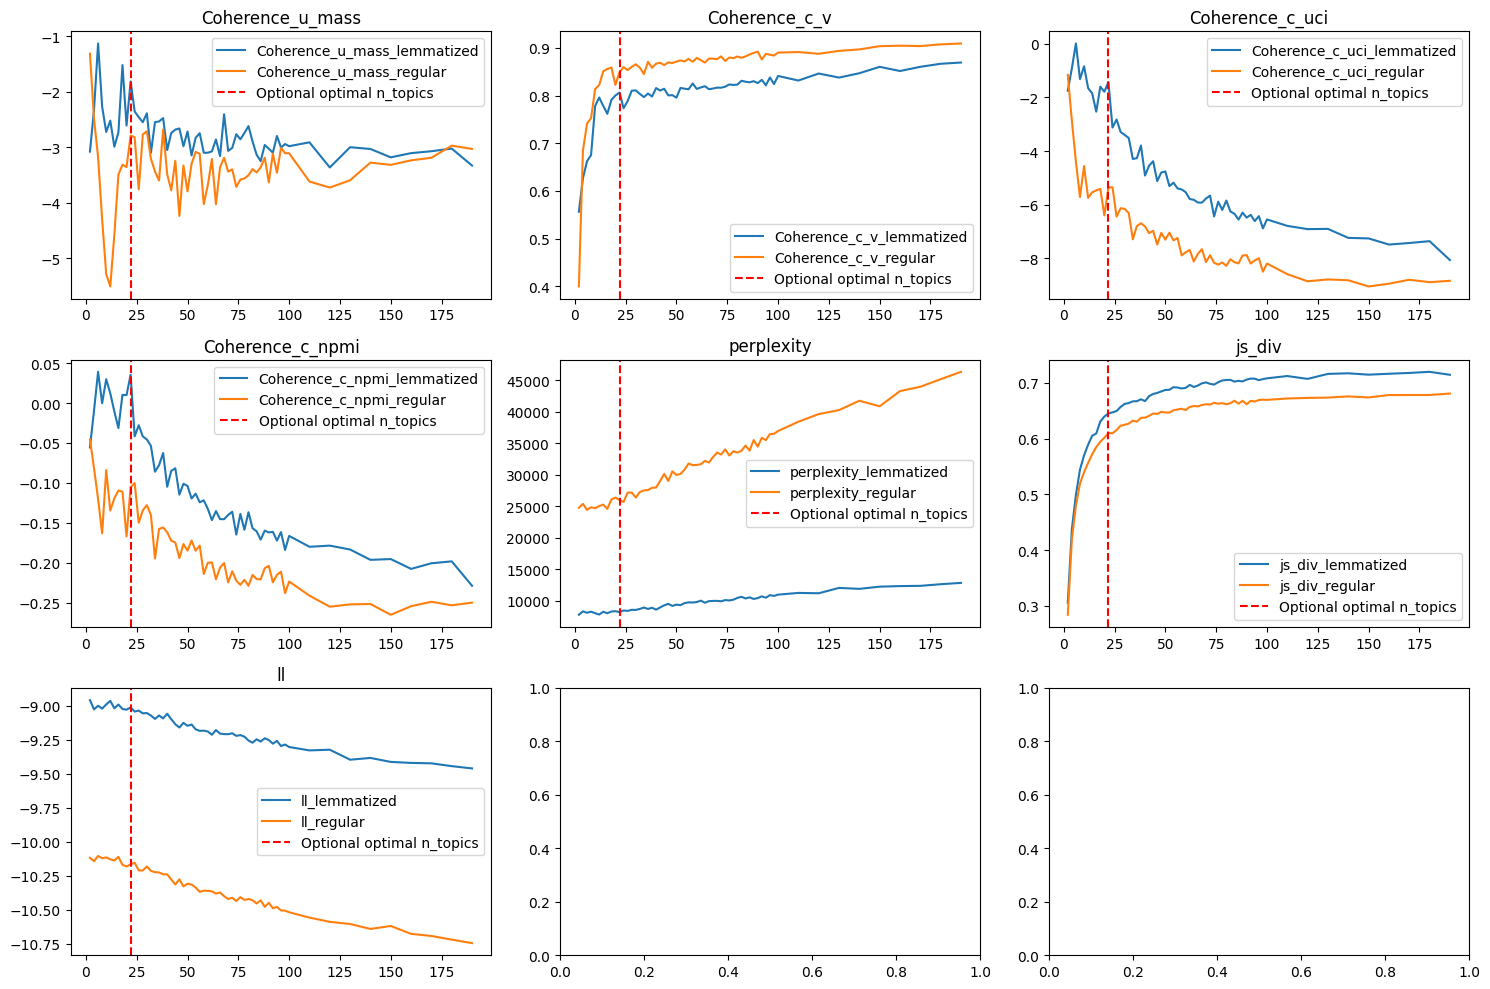

In [22]:
tp_comparison = tp_simulation_results_lem.join(tp_simulation_results, lsuffix="_lemmatized", rsuffix="_regular")

metrics = tp_simulation_results_lem.columns
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))  # Adjust the figure size as necessary
axes = axes.flatten()
# Loop through the metrics and plot
for i, metric in enumerate(metrics):
    # Topic Modeling Toolbox comparison plots
    cols_tp = [f"{metric}_lemmatized", f"{metric}_regular"]
    axes[i].plot(tp_comparison.index, tp_comparison[cols_tp[0]], label=cols_tp[0])
    axes[i].plot(tp_comparison.index, tp_comparison[cols_tp[1]], label=cols_tp[1])
    axes[i].axvline(x=22, color='r', linestyle='--', label='Optional optimal n_topics')

    axes[i].set_title(f"{metric}")
    axes[i].legend()

# Adjust layout

plt.tight_layout()
plt.show()


The perplexity reaches its minimum value quite early, around 15 topics. Various coherence measures suggest that the optimal number of topics lies between 15-25. However, according to other studies, the most reliable coherence metric is C_V, which converges to the optimal number of topics at approximately 15. The JS measure (Jensen–Shannon divergence) appears to stabilize after 25-50 topics, though it is primarily used as a sanity check.

The comparison between lemmatized and regular text is not significant in terms of absolute numbers due to the difference in their vocabularies (25,000 unique words for regular text versus 12,000 for lemmatized text). The main objective was to observe whether their metrics behave differently as a function of the number of topics.

Many parameters can significantly influence the optimal number of topics, such as the initial parameters for the LDA model and the extent to which common words are removed. I came across the article [Is Automated Topic Model Evaluation Broken? The Incoherence of Coherence:
The Incoherence of Coherence](https://arxiv.org/pdf/2107.02173), which argues that current evaluation methods, like perplexity and coherence, are inadequate, and human evaluation remains the best measure. I have experimented with various numbers of topics to determine the optimal count.

### Selected topic model analysis

In [151]:
import pandas as pd

def generate_dominant_topic_df(model, corpus, is_tomotopy=False):
    df_topic_sents_keywords = pd.DataFrame()

    if is_tomotopy:
        for i, doc in enumerate(model.docs):
            topic_dist, _ = model.infer(doc)
            topic_num = topic_dist.argmax()
            prop_topic = topic_dist[topic_num]
            topic_keywords = ", ".join(word for word, _ in model.get_topic_words(topic_num))
            df_topic_sents_keywords = pd.concat(
                [df_topic_sents_keywords, 
                 pd.DataFrame([[int(topic_num), round(prop_topic, 4), topic_keywords]], 
                              columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])], 
                ignore_index=True)
    else:
        for i, row_list in enumerate(model[corpus]):
            row = row_list[0] if model.per_word_topics else row_list
            row = sorted(row, key=lambda x: (x[1]), reverse=True)
            for j, (topic_num, prop_topic) in enumerate(row):
                if j == 0:
                    wp = model.show_topic(topic_num)
                    topic_keywords = ", ".join([word for word, prop in wp])
                    df_topic_sents_keywords = pd.concat(
                        [df_topic_sents_keywords, 
                         pd.DataFrame([[int(topic_num), round(prop_topic, 4), topic_keywords]], 
                                      columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])], 
                        ignore_index=True)
                else:
                    break

    contents = pd.Series([' '.join(doc) for doc in corpus])
    df_topic_sents_keywords = pd.concat([df_topic_sents_keywords, contents], axis=1)
    df_topic_sents_keywords.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Text']
    df_topic_sents_keywords["book"] = df_by_book.reset_index()["book"]

    # Format
    df_dominant_topic = df_topic_sents_keywords.reset_index()
    df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'book']
    return df_dominant_topic

import re

def print_top_topics_by_percentage(model, df_dominant_topic, model_type, num_words=15):
    topics_by_freq = df_dominant_topic.groupby("Dominant_Topic")["Document_No"].count().sort_values(ascending=False).to_frame()
    topics_by_freq["freq"] = topics_by_freq["Document_No"]/topics_by_freq["Document_No"].sum()
    topics_by_freq.reset_index(inplace=True)
    sorted_topics = topics_by_freq.sort_values(by="freq", ascending=False)["Dominant_Topic"].to_list()
    
    if model_type=="gensim":
        topics = model.print_topics(num_topics=-1, num_words=num_words)  # Adjust num_words as needed
    if model_type=="tomotopy":
        topics = [model.get_topic_words(k_topic, top_n=num_words) for k_topic in range(model.k) ]
    topics = [topics[int(i)] for i in sorted_topics]
    # Clean the topics to remove probabilities
    cleaned_topics = []
    if model_type=="gensim":
        for topic_no, topic in topics:
            # Using a regular expression to find words in quotes
            words = re.findall(r'"([^"]*)"', topic)
            cleaned_topics.append(', '.join(sorted(words)))
    if model_type=="tomotopy":
        for topic in topics:
            words = [w[0] for w in topic]
            cleaned_topics.append(', '.join(sorted(words)))

    print(f"{model_type} {num_topics=}, sorted by % from all docs")
    for i, topic in zip(sorted_topics,cleaned_topics):
        doc_n = topics_by_freq[(topics_by_freq["Dominant_Topic"]==i)]["Document_No"].values[0]
        doc_ratio = topics_by_freq[(topics_by_freq["Dominant_Topic"]==i)]["freq"].values[0]
        print(f"Topic {i} ({doc_n} docs, {doc_ratio:2%} from all docs): {topic}")



In [152]:
print('regular text, removed the following words')
texts_lem, id2word_lem, corpus_lem = generate_components("lemmatized_text", 42, 1, 4, 8, 10)
print('\nlemmatized text, removed the following words')
texts, id2word, corpus = generate_components("processed_text", 42, 1, 4, 8, 10)
corpus_tp = tp.utils.Corpus()
for text in texts:
    corpus_tp.add_doc(words=text)
corpus_tp_lem = tp.utils.Corpus()
for text in texts_lem:
    corpus_tp_lem.add_doc(words=text)


regular text, removed the following words
Removed ['כול', 'לוא', 'יום', 'איש', 'עם', 'בן', 'ישראל', 'ארץ'], ['למיום', 'לאר', 'חירם', 'אח_רע', 'שחרע', 'הכנעה', 'ונקח', 'שם_שת', 'וזנוח', 'היקח'] from text

lemmatized text, removed the following words
Removed ['כול', 'לוא', 'כיא', 'די', 'ישראל', 'ולוא', 'יהוה', 'וכול'], ['למיום', 'באחיו', 'גנבי', 'חירם', 'כחבר', 'ועי', 'תוה', 'מפינו', 'שחרע', 'נאמנים'] from text


In [153]:
num_topics = 20
k = num_topics
model_tp = tp.LDAModel(k=num_topics, alpha=1.0/k, eta=1.0/k, min_cf=0, corpus=corpus_tp, seed=42)
model_tp.train(200)

model_tp_lem = tp.LDAModel(k=num_topics, alpha=1.0/k, eta=1.0/k, min_cf=0, corpus=corpus_tp_lem, seed=42)
model_tp_lem.train(200)
# model_gensim = gensim.models.LdaModel(corpus=corpus, id2word=id2word, num_topics=k, random_state=42, alpha=1.0/k, eta=1.0/k)
# model_gensim_lem = gensim.models.LdaModel(corpus=corpus_lem, id2word=id2word_lem, num_topics=k, random_state=42, alpha=1.0/k, eta=1.0/k)
# df_dominant_topic = generate_dominant_topic_df(model_gensim_lem, corpus_lem)
# df_dominant_topic = generate_dominant_topic_df(model_gensim, corpus)



df_dominant_topic_tp = generate_dominant_topic_df(model_tp, corpus_tp,is_tomotopy=True)
print("Regular text")
print_top_topics_by_percentage(model_tp, df_dominant_topic_tp, "tomotopy", num_words=15)
print("-------------------------------------------------------------------------------------")
df_dominant_topic_tp_lem = generate_dominant_topic_df(model_tp_lem, corpus_tp_lem,is_tomotopy=True)
print("Lemmatized text")
print_top_topics_by_percentage(model_tp_lem, df_dominant_topic_tp_lem, "tomotopy", num_words=15)

/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_10904/3329442220.py:4: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model_tp.train(200)
/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_10904/3329442220.py:7: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model_tp_lem.train(200)


Regular text
tomotopy num_topics=20, sorted by % from all docs
Topic 10 (85 docs, 22.193211% from all docs): אש, בה, בו, בכול, בם, וא, ול, ום, ות, יחד, ים, כה, לכה, לם, קודש
Topic 3 (39 docs, 10.182768% from all docs): אחד, איש, אמר, בית, בכול, בן, בני, בני_ישראל, דבר, הארץ, הואה, המה, יהודה, יעקוב, עמו
Topic 6 (39 docs, 10.182768% from all docs): אלן, אמר, אנה, אנון, ארעא, באדין, בה, דן, וכל, ולא, כדי, להון, לכול, שמיא, שנין
Topic 2 (30 docs, 7.832898% from all docs): בארץ, בכל, הארץ, ואין, ובכל, וכל, ולא, ועד, ירושלים, לך, לכל, עליון, עשה, רבים, רשעים
Topic 1 (23 docs, 6.005222% from all docs): אור, איש, אמת, ביחד, בכול, דעת, הואה, הון, והוא, לאיש, לכול, משפט, עולם, צדק, רשע
Topic 11 (19 docs, 4.960836% from all docs): אמין, דא, דן_משח, ולא, ומן_תרעא, ין, להוה, מלכא, מלכותא, פתי, קנין_תרין, רוח, תרין, תרע, תרעא_דן
Topic 19 (18 docs, 4.699739% from all docs): אלוהיכה, אלוהינו, אמן_אמן, ברוך_אדוני, דברתה, ויואמר, ויסעו, לבנו, לעשות, לפניכה, לתת, מושה, נא, נתתה, עשיתה
Topic 7 (14 docs, 

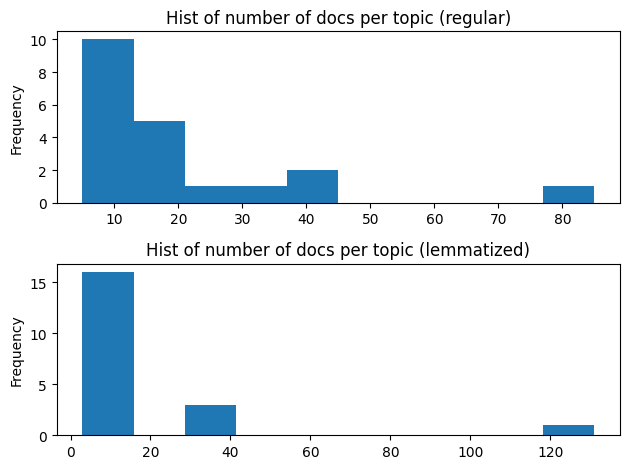

In [154]:
fig, ax = plt.subplots(2,1)
df_dominant_topic_tp.groupby("Dominant_Topic")["Document_No"].count().plot(kind="hist", title="Hist of number of docs per topic (regular)",ax=ax[0])
df_dominant_topic_tp_lem.groupby("Dominant_Topic")["Document_No"].count().plot(kind="hist", title="Hist of number of docs per topic (lemmatized)",ax=ax[1])
plt.tight_layout()

My only concern about lemmatized text is that I don't really trust the model that lemmitazaion did for it. I saw many words that he was not so successful in lemmatizing.
We can also see the the distributions are very different, which will probably gives as a pretty bias results in case of the lemmatized text (there is a topic which is dominant with 35% of the docs).

In [155]:
df_by_book = pd.read_csv('data/full_data_nonbib_01_05_24.csv')
by_book = df_by_book.groupby("book")["processed_text"].apply(list).str.join(" ")
df_by_book_ = pd.merge(by_book, df_by_book[["book","label","section"]], on="book", how="inner").drop_duplicates()
df_by_book = pd.merge(df_dominant_topic_tp[["Dominant_Topic","book"]], df_by_book, on="book")


In [156]:
from collections import Counter
import warnings

def generate_word_dist_plot(model, model_type, num_words_per_topic, biggest_topics,topics_to_show,title):
    warnings.filterwarnings("ignore")
    if model_type == "gensim":
        topics = model.show_topics(num_topics=-1, formatted=False, num_words=num_words_per_topic)
    if model_type == "tomotopy":
        topics = [model_tp.get_topic_words(k_topic, top_n=num_words_per_topic) for k_topic in range(model_tp.k) ]
        topics = enumerate(topics)
    data_flat = [w for w_list in texts for w in w_list]
    counter = Counter(data_flat)
    
    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i , weight, counter[word]])
    
    df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        
    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(topics_to_show//2, 2, figsize=(20,15), sharey=True)
    cols = [color for name, color in mcolors.XKCD_COLORS.items()]
    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==biggest_topics[i], :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==biggest_topics[i], :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        # ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
        ax.set_title('Topic: ' + str(biggest_topics[i]), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels([w[::-1] for w in df.loc[df.topic_id==biggest_topics[i], 'word']], rotation=30, horizontalalignment= 'right') #reverse heb
        ax.tick_params(axis='x', labelrotation = 45)
        ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')
    
    fig.tight_layout(w_pad=2)    
    fig.suptitle(title, fontsize=22, y=1.05)    
    plt.show()
    warnings.filterwarnings("default")



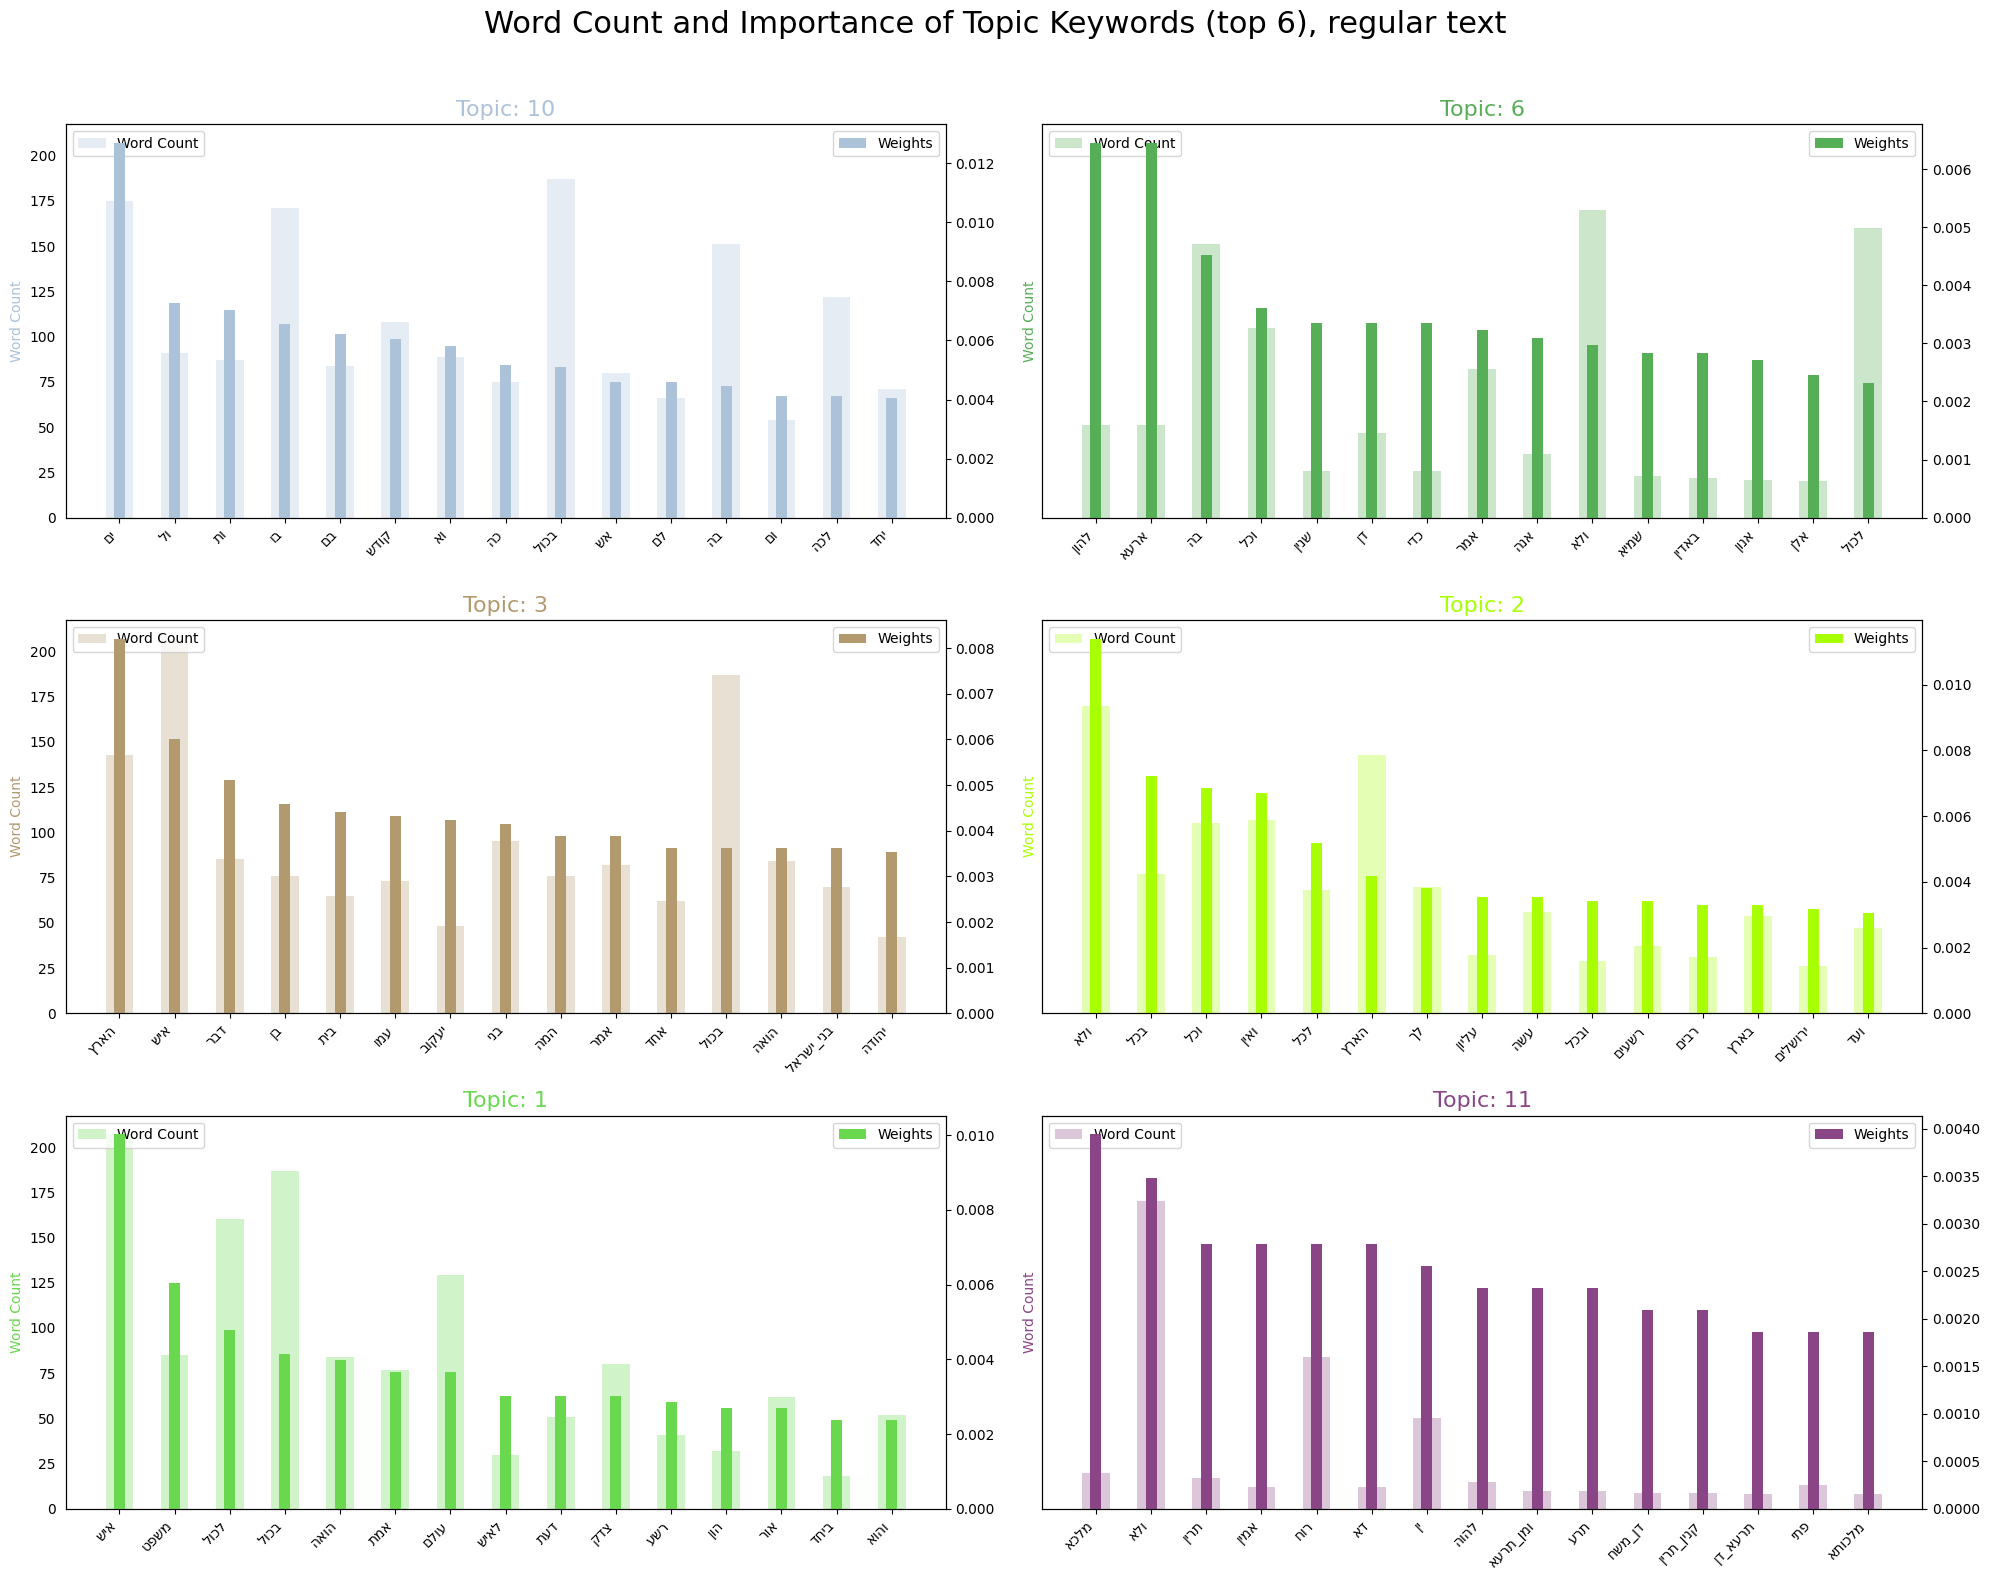

In [157]:
topics_to_show = 6
biggest_topics = df_dominant_topic_tp.groupby("Dominant_Topic")["Document_No"].count().sort_values(ascending=False)[:topics_to_show].index.to_list()
generate_word_dist_plot(model_tp, "tomotopy", 15, biggest_topics,topics_to_show,f'Word Count and Importance of Topic Keywords (top {topics_to_show}), regular text')

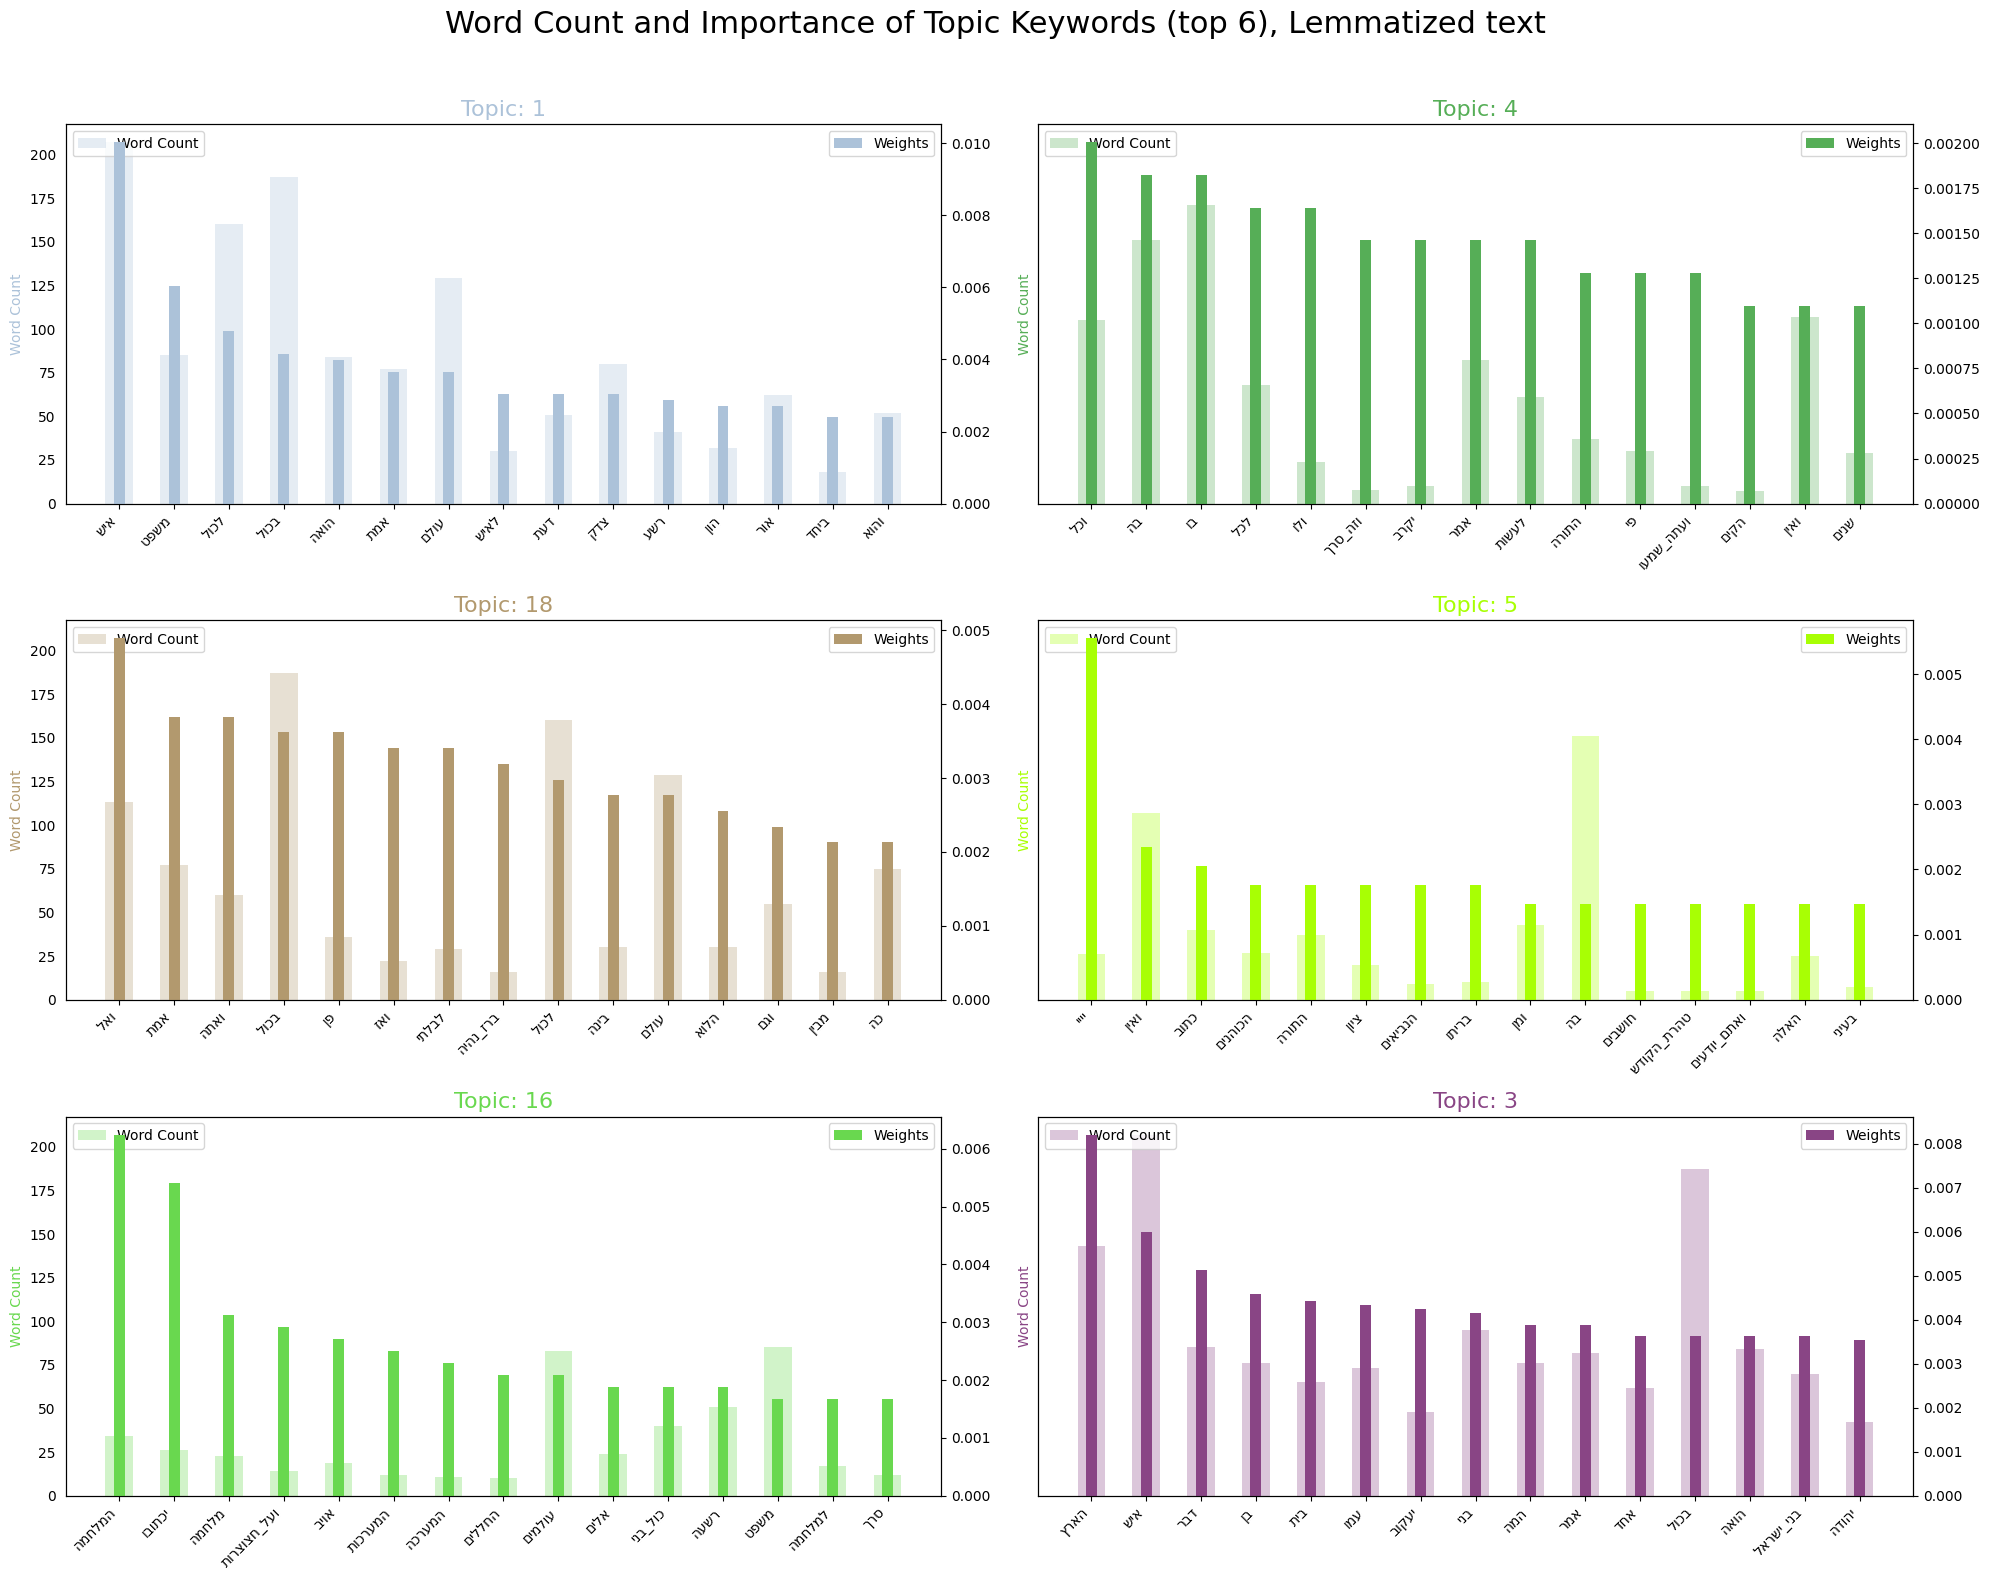

In [158]:
biggest_topics = df_dominant_topic_tp_lem.groupby("Dominant_Topic")["Document_No"].count().sort_values(ascending=False)[:topics_to_show].index.to_list()
generate_word_dist_plot(model_tp_lem, "tomotopy", 15, biggest_topics,topics_to_show,f'Word Count and Importance of Topic Keywords (top {topics_to_show}), Lemmatized text')

In [159]:
df_by_book.to_csv("data/full_data_nonbib_01_05_24_with_topics.csv")

## Clustering

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


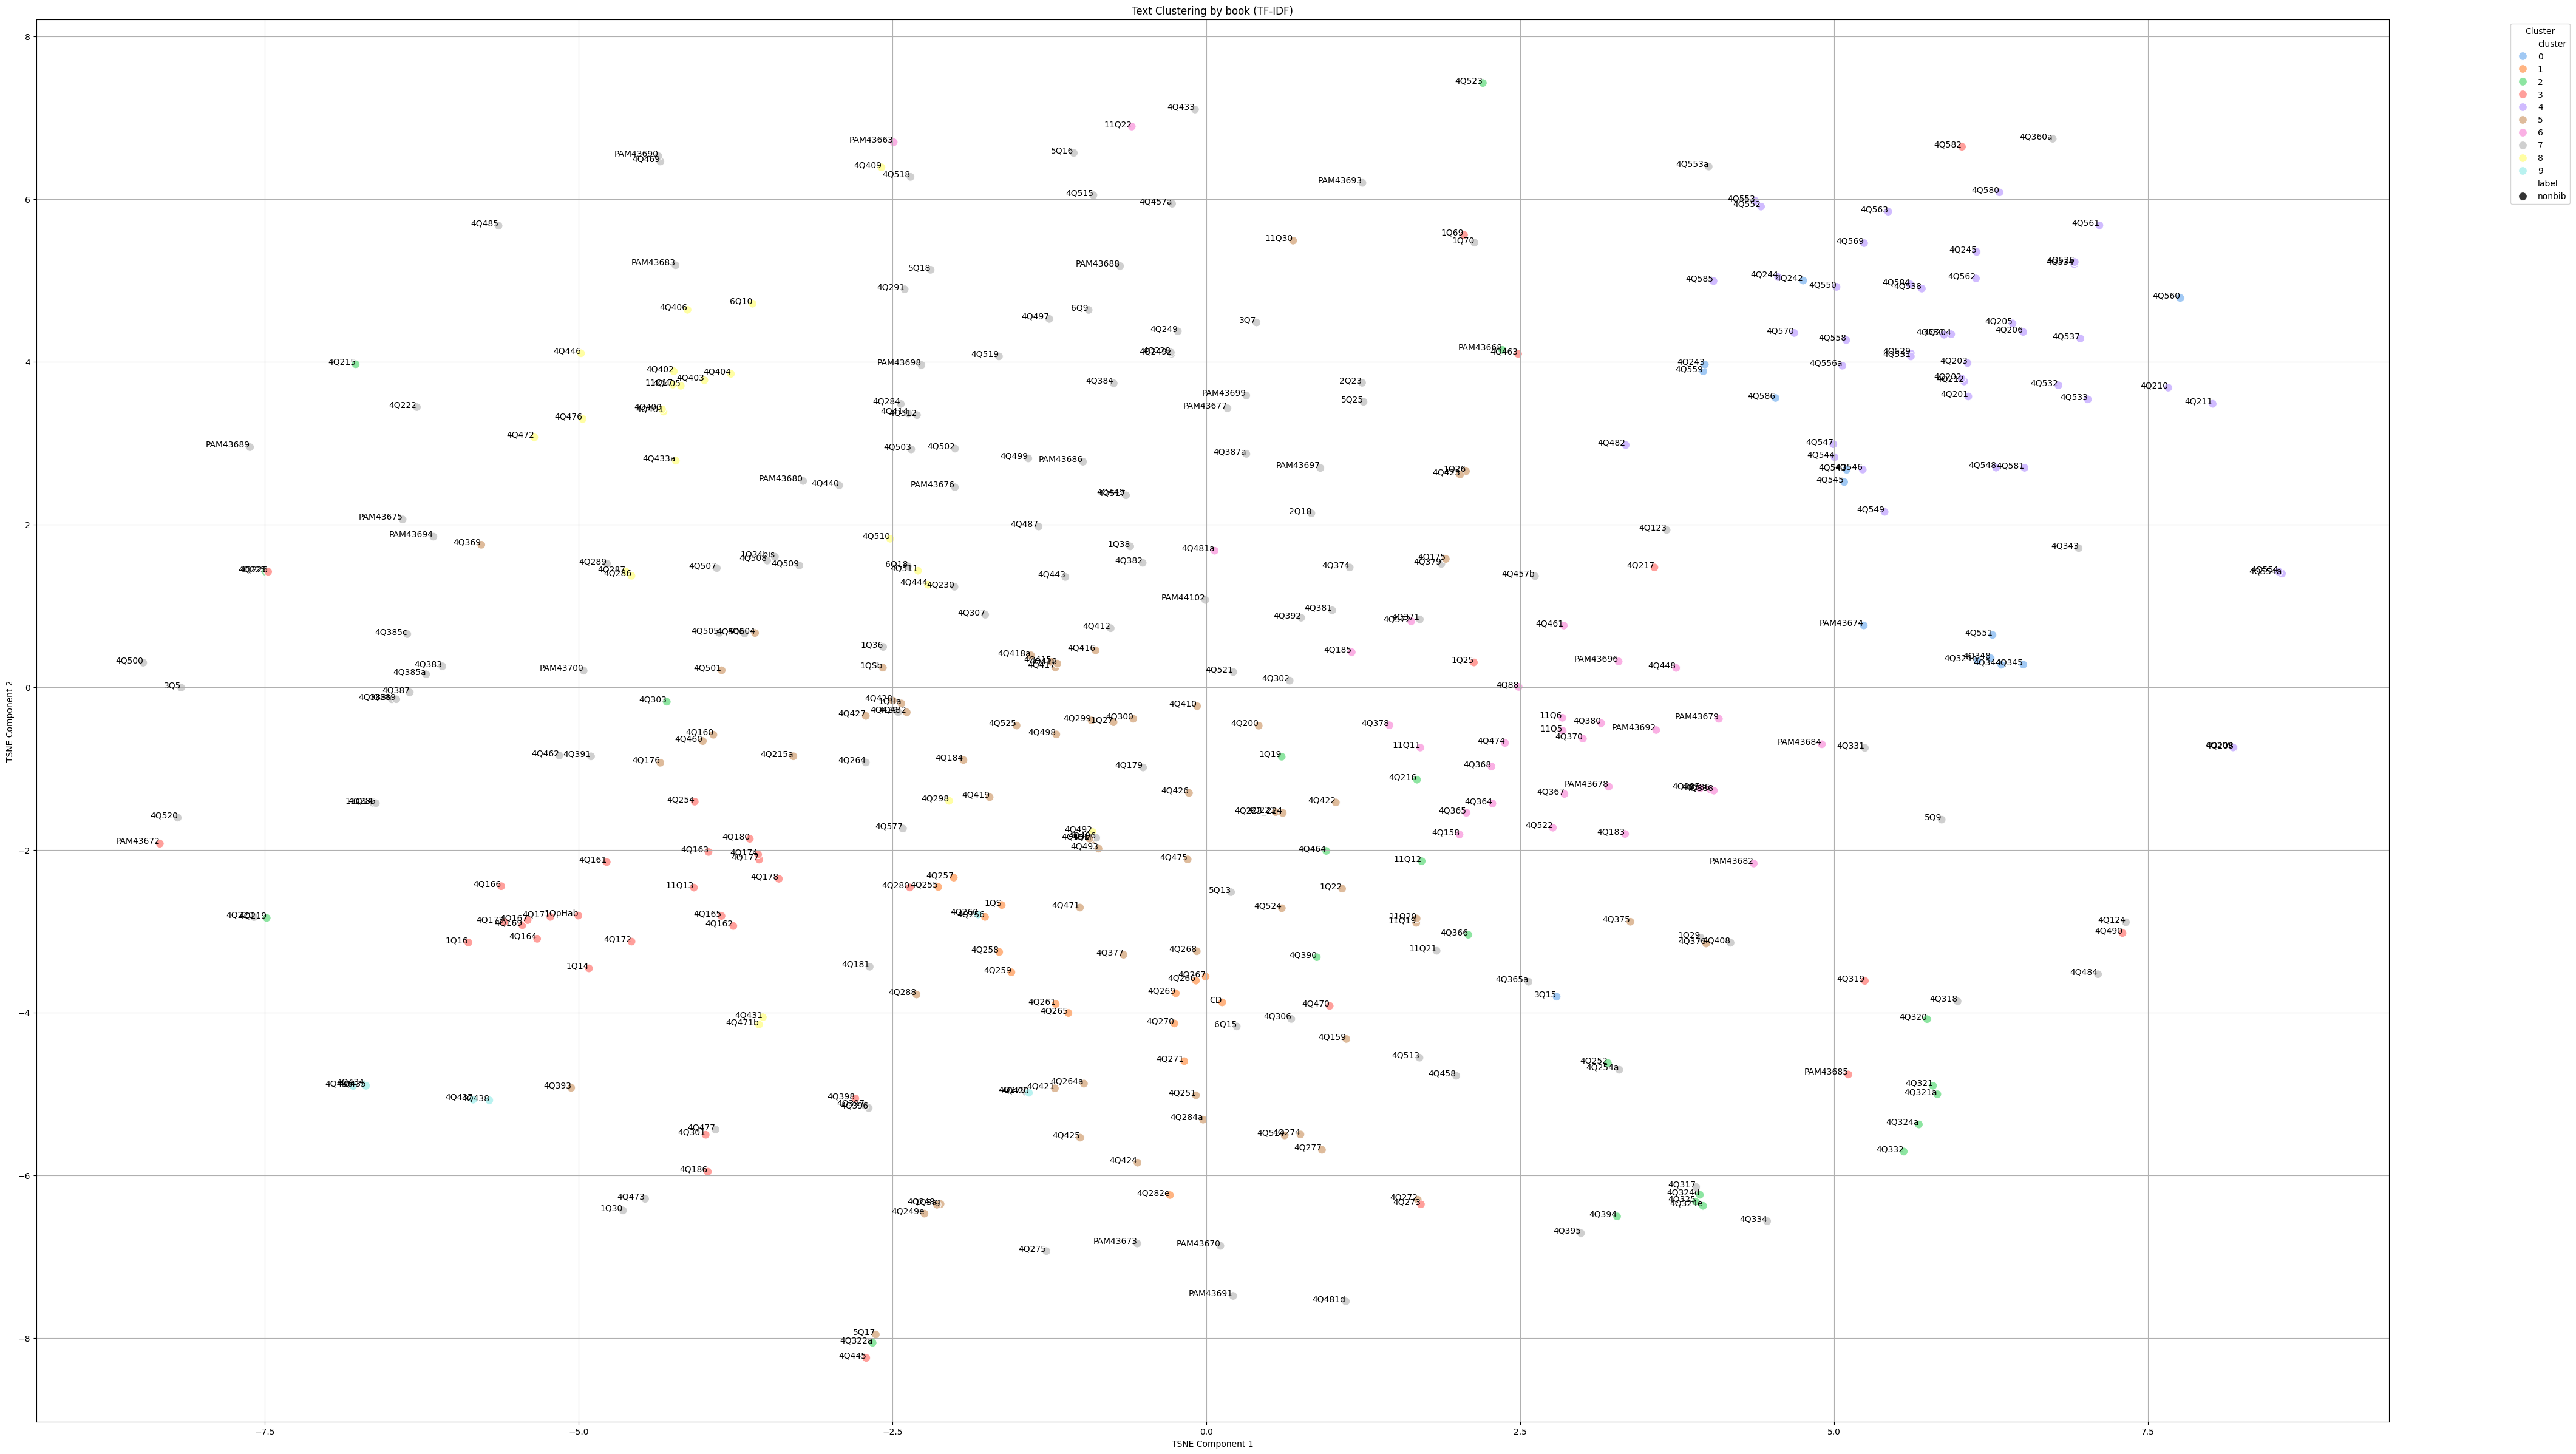

In [39]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
# Step 1: Prepare Data
df_sampled = df_by_book.sample(frac=1, random_state=42)
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_sampled['processed_text'])

# Step 2: Clustering
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(X)
df_sampled['cluster'] = clusters

# Visualization
tsne = TSNE(n_components=2, random_state=0, perplexity=100)
components = tsne.fit_transform(X.toarray())

# Plot using seaborn for the scatter plot
plt.figure(figsize=(50, 30))
scatter = sns.scatterplot(x=components[:,0], y=components[:,1], hue=df_sampled['cluster'], palette='pastel', style=df_sampled['label'], s=100)

# Adding text labels
for i, text in enumerate(df_sampled['book']):
    plt.text(components[i, 0], components[i, 1], text, fontdict=dict(color='black', size=10), ha='right')

plt.title('Text Clustering by book (TF-IDF)')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
# plt.savefig("tsne_by_book.png")
plt.show()

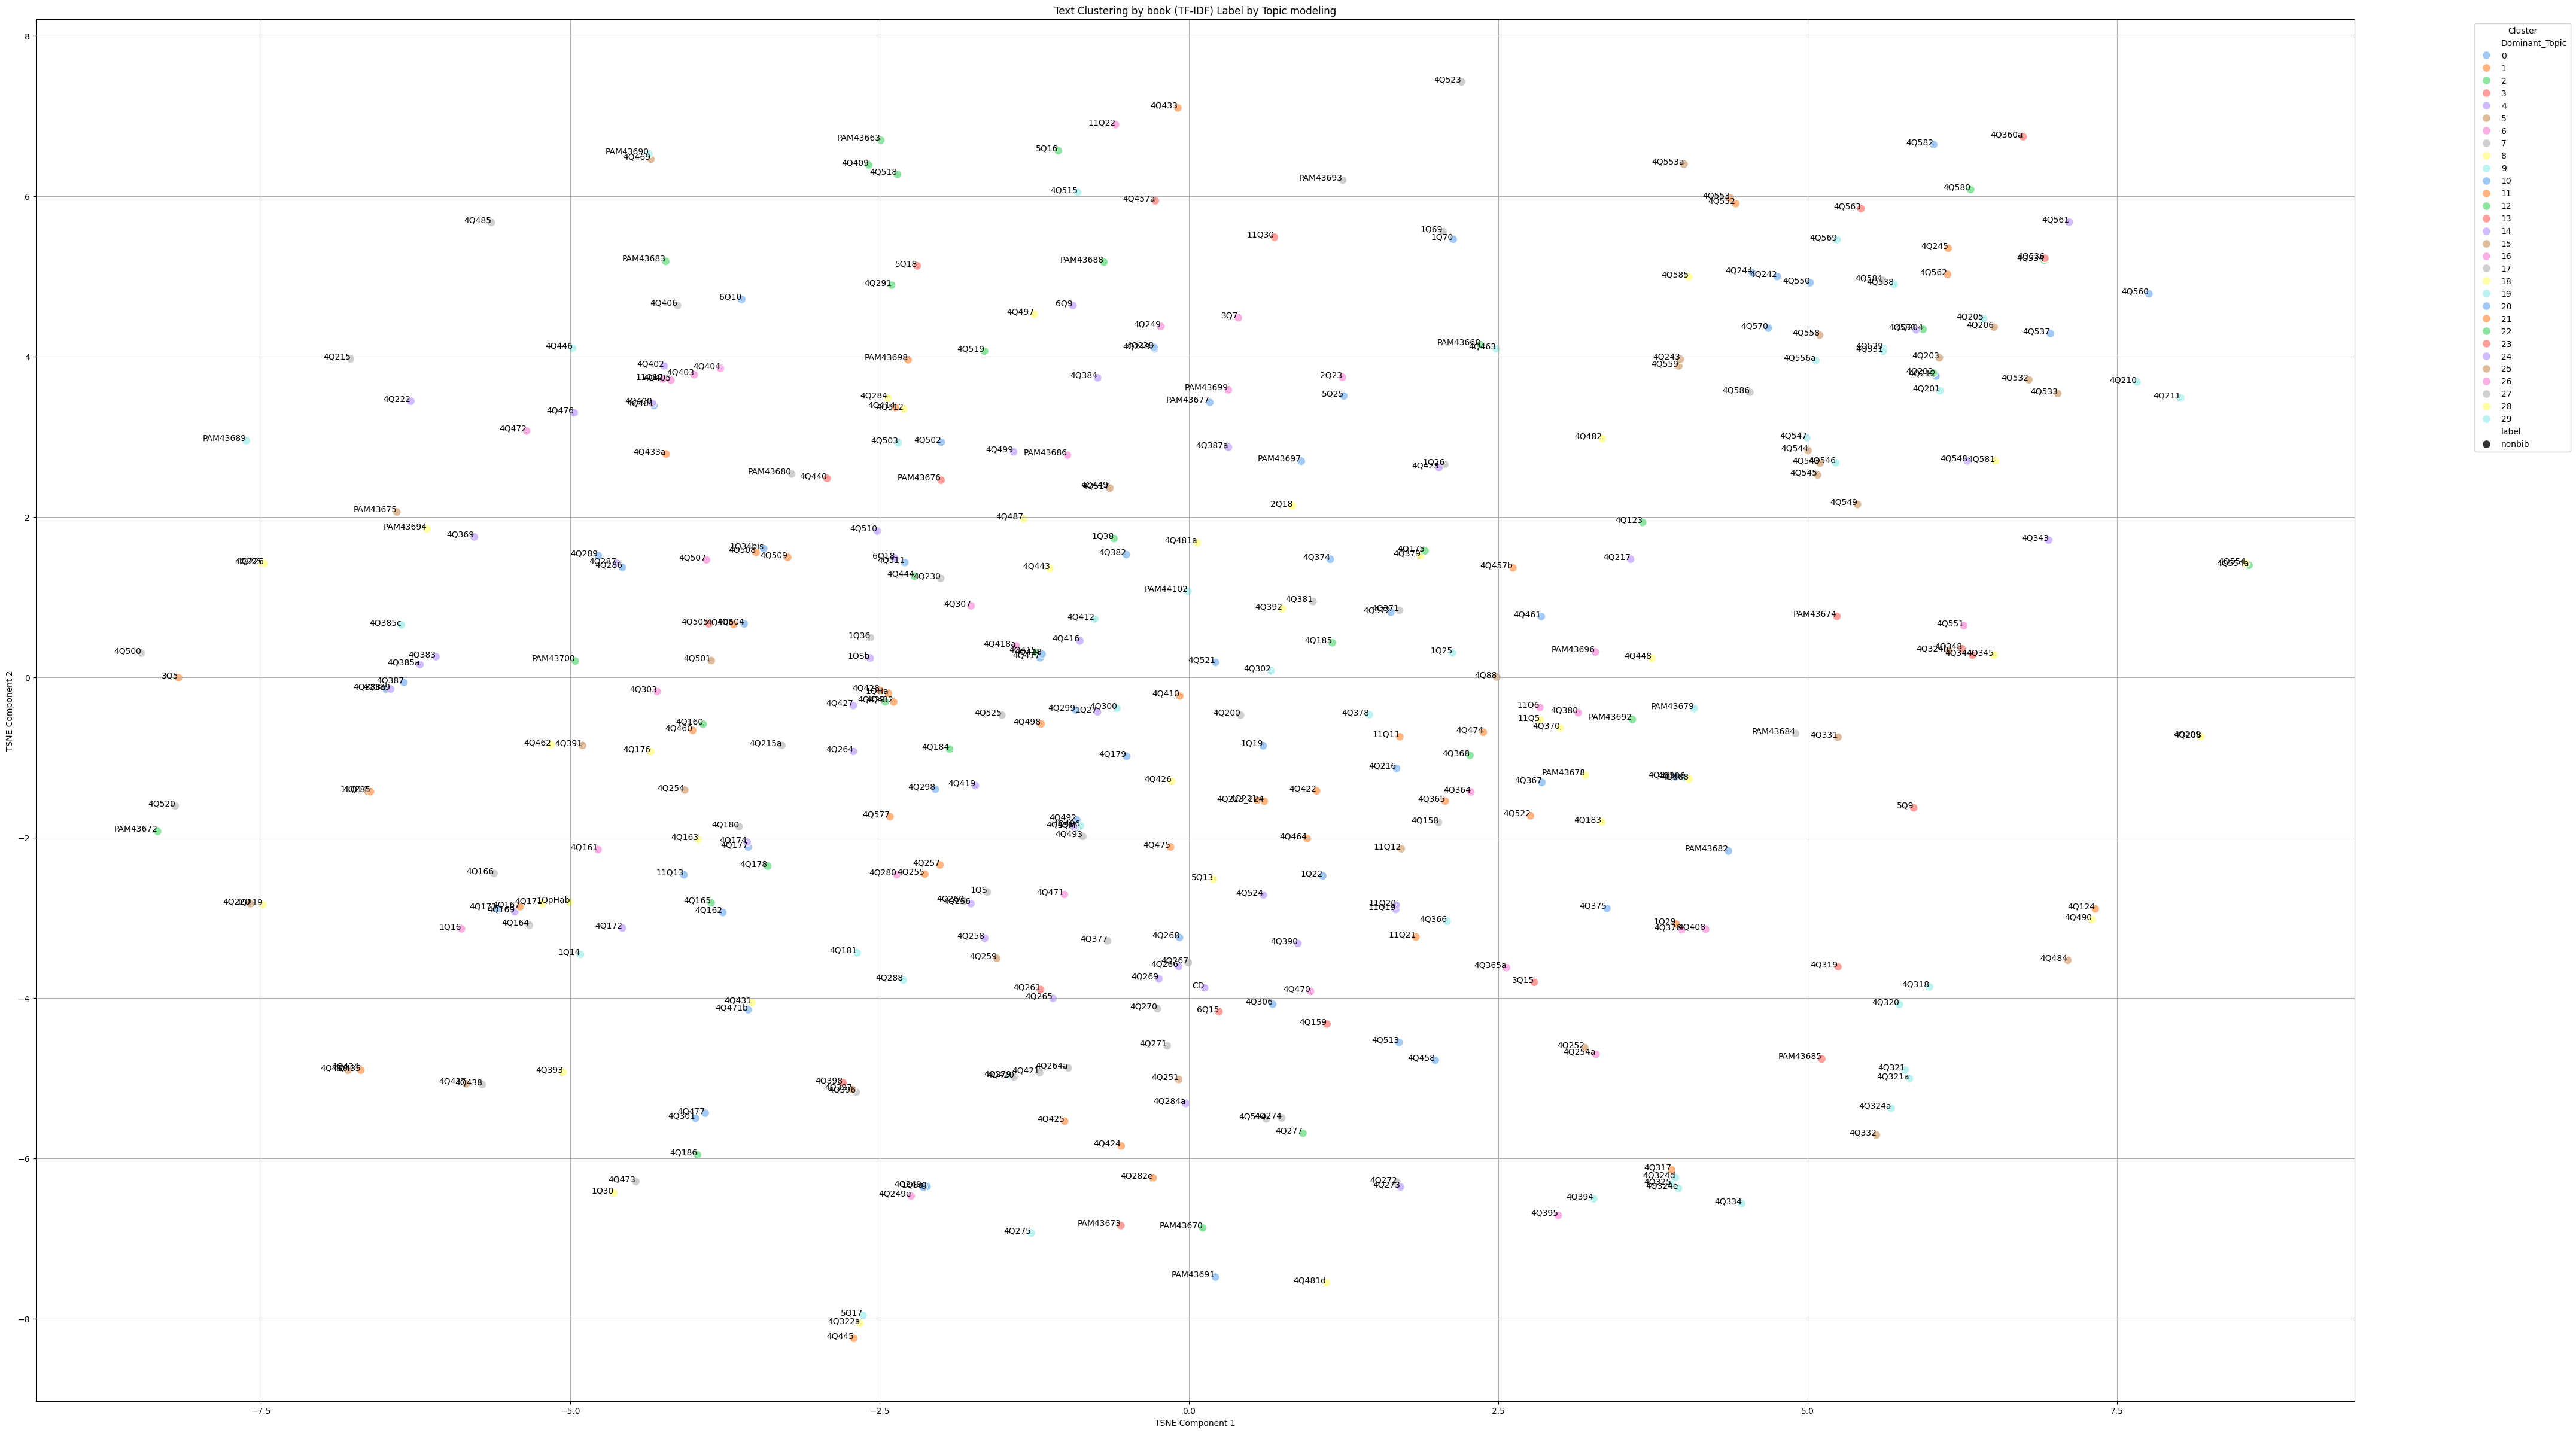

In [40]:

plt.figure(figsize=(50, 30))
scatter = sns.scatterplot(x=components[:,0], y=components[:,1], hue=df_sampled['Dominant_Topic'], palette='pastel', style=df_sampled['label'], s=100)

# Adding text labels
for i, text in enumerate(df_sampled['book']):
    plt.text(components[i, 0], components[i, 1], text, fontdict=dict(color='black', size=10), ha='right')

plt.title('Text Clustering by book (TF-IDF) Label by Topic modeling')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

### Tomotopy package - Hierarchical Dirichlet process

The Hierarchical Dirichlet Process (HDP) is an advanced Bayesian model that is particularly useful for problems where you need to infer the number of underlying groups or patterns in data without specifying the number in advance. It extends the Dirichlet Process (DP) by linking multiple DPs through a shared base distribution, allowing for a hierarchy of groups that can share statistical strength.

In the context of topic modeling, the HDP is advantageous because it can automatically determine the number of topics present in a collection of documents.

[Hierarchical Dirichlet process](https://en.wikipedia.org/wiki/Hierarchical_Dirichlet_process)

In [53]:
import tomotopy as tp
from gensim.models import CoherenceModel

def eval_coherence(topics_dict, word_list, coherence_type='c_v'):
    '''Wrapper function that uses gensim Coherence Model to compute topic coherence scores
    
    ** Inputs **
    topic_dict: dict -> topic dictionary from train_HDPmodel function
    word_list: list -> lemmatized word list of lists
    coherence_typ: str -> type of coherence value to comput (see gensim for opts)
    
    ** Returns **
    score: float -> coherence value
    '''
    
    # Build gensim objects
    vocab = corpora.Dictionary(word_list)
    corpus = [vocab.doc2bow(words) for words in word_list]
    
    # Build topic list from dictionary
    topic_list=[]
    for k, tups in topics_dict.items():
        topic_tokens=[]
        for w, p in tups:
            topic_tokens.append(w)
            
        topic_list.append(topic_tokens)
            

    # Build Coherence model
    print("Evaluating topic coherence...")
    cm = CoherenceModel(topics=topic_list, corpus=corpus, dictionary=vocab, texts=word_list, 
                    coherence=coherence_type)
    
    score = cm.get_coherence()
    print ("Done\n")
    return score

term_weight = tp.TermWeight.ONE
hdp = tp.HDPModel(tw=term_weight, 
                  min_cf=5, #using only words that appeared in at least 5 docs
                  rm_top=3, #Removing top 3 words
                  gamma=0.5, #assuming documents share many topics 
                  alpha=0.1, #while individual documents only talk about few topics
                  initial_k=2, #prior
                  seed=42)

# Add docs to train
for vec in texts:
    hdp.add_doc(vec)

# Initiate sampling burn-in  (i.e. discard N first iterations)
hdp.burn_in = 100
hdp.train(0)
print('Num docs:', len(hdp.docs), ', Vocab size:', hdp.num_vocabs,
      ', Num words:', hdp.num_words)
print('Removed top words:', hdp.removed_top_words)
hdp_res = []
# Train model
for i in range(0, 1500, 100):
    hdp.train(100, show_progress=True) # 100 iterations at a time
    topics_d = get_hdp_topics(hdp, top_n=10)
    coherence_score = eval_coherence(topics_d, texts)
    print('Iteration: {}\tLog-likelihood: {}\tperpelexity: {}\tcoherence: {}\tNum. of topics: {}'.format(i, hdp.ll_per_word,hdp.perplexity, coherence_score, hdp.live_k))
    hdp_res.append((i, hdp.ll_per_word, hdp.live_k,hdp.perplexity,coherence_score))
  

/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_38145/474953805.py:54: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  hdp.train(0)
/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_38145/474953805.py:61: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  hdp.train(100, show_progress=True) # 100 iterations at a time


Num docs: 383 , Vocab size: 4167 , Num words: 76540
Removed top words: ['כול', 'לוא', 'איש']


Iteration: 100%|██████████| 100/100 [00:00<00:00, 316.53it/s, # Topics: 12, LLPW: -7.989593]


Evaluating topic coherence...
Done

Iteration: 0	Log-likelihood: -7.961433643241262	perpelexity: 2868.1819560561044	coherence: 0.4407049586714516	Num. of topics: 14


Iteration: 100%|██████████| 100/100 [00:00<00:00, 199.48it/s, # Topics: 22, LLPW: -7.897986]


Evaluating topic coherence...
Done

Iteration: 100	Log-likelihood: -7.901180758783392	perpelexity: 2700.4690490729477	coherence: 0.517605954383019	Num. of topics: 21


Iteration: 100%|██████████| 100/100 [00:00<00:00, 228.98it/s, # Topics: 20, LLPW: -7.860089]


Evaluating topic coherence...
Done

Iteration: 200	Log-likelihood: -7.85472132409245	perpelexity: 2577.8766214020097	coherence: 0.4878112591877691	Num. of topics: 20


Iteration: 100%|██████████| 100/100 [00:00<00:00, 182.28it/s, # Topics: 25, LLPW: -7.782012]


Evaluating topic coherence...
Done

Iteration: 300	Log-likelihood: -7.771946813654021	perpelexity: 2373.086751864619	coherence: 0.46108303591938915	Num. of topics: 27


Iteration: 100%|██████████| 100/100 [00:00<00:00, 175.37it/s, # Topics: 32, LLPW: -7.640691]


Evaluating topic coherence...
Done

Iteration: 400	Log-likelihood: -7.636433060825852	perpelexity: 2072.3387115108085	coherence: 0.46634779569897367	Num. of topics: 32


Iteration: 100%|██████████| 100/100 [00:00<00:00, 170.32it/s, # Topics: 38, LLPW: -7.608089]


Evaluating topic coherence...
Done

Iteration: 500	Log-likelihood: -7.609573348570904	perpelexity: 2017.417180151023	coherence: 0.4858133680479577	Num. of topics: 37


Iteration: 100%|██████████| 100/100 [00:00<00:00, 166.73it/s, # Topics: 38, LLPW: -7.594308]


Evaluating topic coherence...
Done

Iteration: 600	Log-likelihood: -7.59622546432222	perpelexity: 1990.6678497824244	coherence: 0.5034043750418628	Num. of topics: 39


Iteration: 100%|██████████| 100/100 [00:00<00:00, 158.87it/s, # Topics: 42, LLPW: -7.595839]


Evaluating topic coherence...
Done

Iteration: 700	Log-likelihood: -7.591029726621032	perpelexity: 1980.3516850354747	coherence: 0.5068466207561163	Num. of topics: 40


Iteration: 100%|██████████| 100/100 [00:00<00:00, 159.65it/s, # Topics: 44, LLPW: -7.594925]


Evaluating topic coherence...
Done

Iteration: 800	Log-likelihood: -7.596788014479707	perpelexity: 1991.7880153399385	coherence: 0.496457659089125	Num. of topics: 41


Iteration: 100%|██████████| 100/100 [00:00<00:00, 146.08it/s, # Topics: 39, LLPW: -7.597640]


Evaluating topic coherence...
Done

Iteration: 900	Log-likelihood: -7.595882129354579	perpelexity: 1989.9845012160768	coherence: 0.49042532940918093	Num. of topics: 40


Iteration: 100%|██████████| 100/100 [00:00<00:00, 151.15it/s, # Topics: 39, LLPW: -7.626079]


Evaluating topic coherence...
Done

Iteration: 1000	Log-likelihood: -7.626985673515673	perpelexity: 2052.8527158712086	coherence: 0.4999744777530579	Num. of topics: 37


Iteration: 100%|██████████| 100/100 [00:00<00:00, 152.28it/s, # Topics: 41, LLPW: -7.620327]


Evaluating topic coherence...
Done

Iteration: 1100	Log-likelihood: -7.623064161269011	perpelexity: 2044.8181928419656	coherence: 0.49805829010439495	Num. of topics: 39


Iteration: 100%|██████████| 100/100 [00:00<00:00, 153.88it/s, # Topics: 39, LLPW: -7.623475]


Evaluating topic coherence...
Done

Iteration: 1200	Log-likelihood: -7.620677661141933	perpelexity: 2039.9440523466938	coherence: 0.4993722685970881	Num. of topics: 41


Iteration: 100%|██████████| 100/100 [00:00<00:00, 156.34it/s, # Topics: 39, LLPW: -7.618905]


Evaluating topic coherence...
Done

Iteration: 1300	Log-likelihood: -7.619475299299059	perpelexity: 2037.4927754127923	coherence: 0.4849664141993455	Num. of topics: 39


Iteration: 100%|██████████| 100/100 [00:00<00:00, 148.82it/s, # Topics: 42, LLPW: -7.608754]


Evaluating topic coherence...
Done

Iteration: 1400	Log-likelihood: -7.607015651304042	perpelexity: 2012.2638309062254	coherence: 0.4832667554441453	Num. of topics: 41


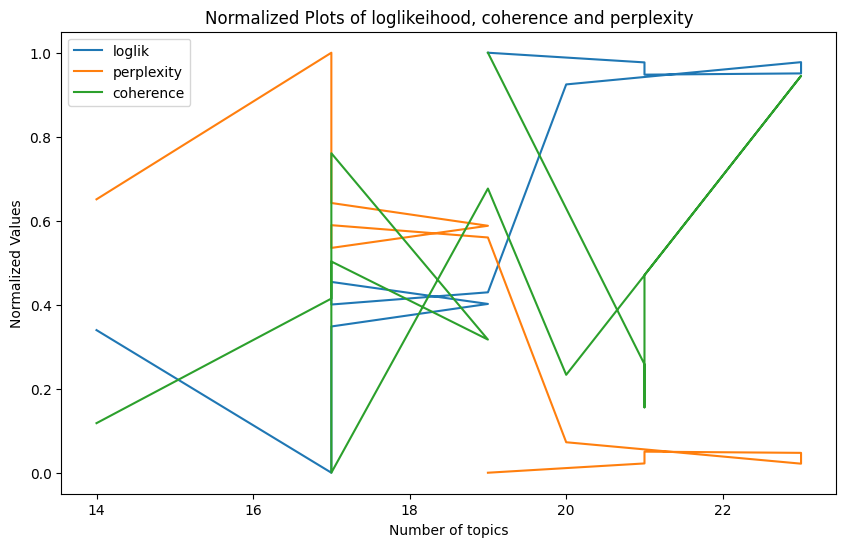

In [48]:
#lemmatized
hdp_res = pd.DataFrame(hdp_res, columns=["iter","loglik","num_topics","perplexity", "coherence"])
hdp_res = hdp_res[["loglik","num_topics","perplexity", "coherence"]].set_index("num_topics")
df = hdp_res
# Normalize data (Min-Max scaling)
df_normalized = (df - df.min()) / (df.max() - df.min())

# Plotting
plt.figure(figsize=(10, 6))
for column in df_normalized.columns:
    plt.plot(df_normalized.index, df_normalized[column], label=column)
plt.title('Normalized Plots of loglikeihood, coherence and perplexity')
plt.xlabel('Number of topics')
plt.ylabel('Normalized Values')
plt.legend()
plt.show()

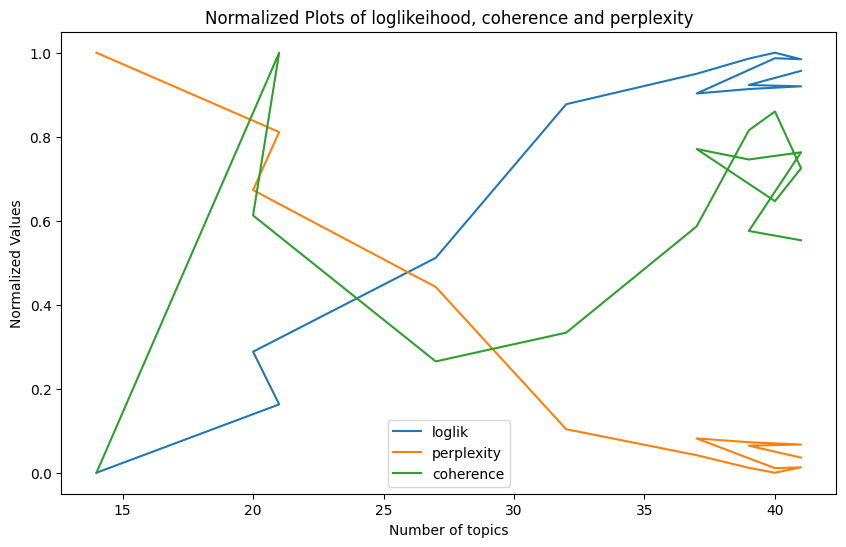

In [54]:
hdp_res = pd.DataFrame(hdp_res, columns=["iter","loglik","num_topics","perplexity", "coherence"])
hdp_res = hdp_res[["loglik","num_topics","perplexity", "coherence"]].set_index("num_topics")
df = hdp_res
# Normalize data (Min-Max scaling)
df_normalized = (df - df.min()) / (df.max() - df.min())

# Plotting
plt.figure(figsize=(10, 6))
for column in df_normalized.columns:
    plt.plot(df_normalized.index, df_normalized[column], label=column)
plt.title('Normalized Plots of loglikeihood, coherence and perplexity')
plt.xlabel('Number of topics')
plt.ylabel('Normalized Values')
plt.legend()
plt.show()

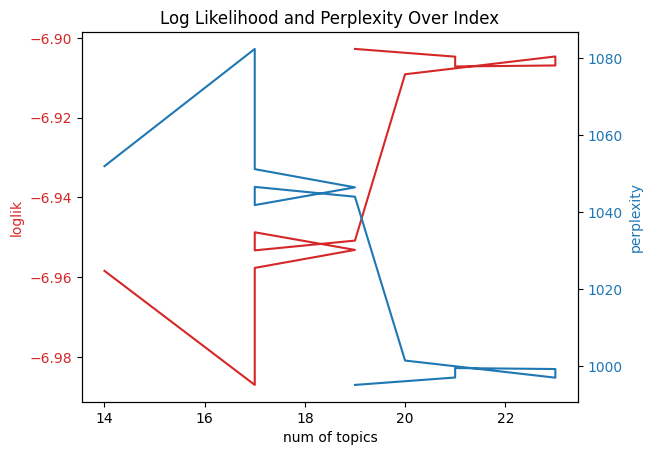

In [49]:
#lemmatized
fig, ax1 = plt.subplots()
# Plot the first column 'loglik'
color = 'tab:red'
ax1.set_xlabel('num of topics')
ax1.set_ylabel('loglik', color=color)
ax1.plot(df.index, df['loglik'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for the 'perplexity' column
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('perplexity', color=color)
ax2.plot(df.index, df['perplexity'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Show the plot
plt.title('Log Likelihood and Perplexity Over Index')
plt.show()

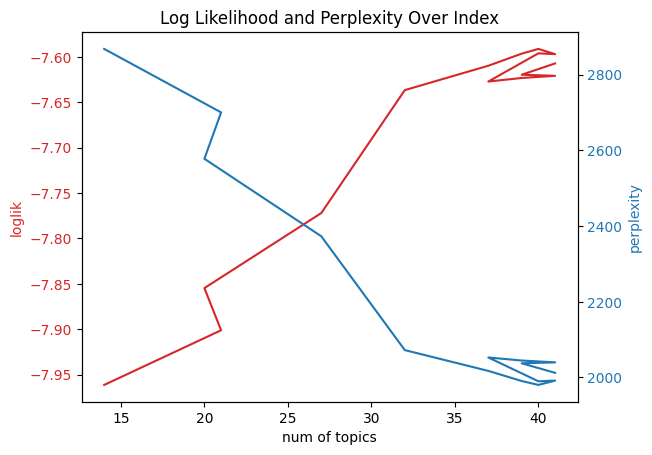

In [55]:

fig, ax1 = plt.subplots()
# Plot the first column 'loglik'
color = 'tab:red'
ax1.set_xlabel('num of topics')
ax1.set_ylabel('loglik', color=color)
ax1.plot(df.index, df['loglik'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for the 'perplexity' column
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('perplexity', color=color)
ax2.plot(df.index, df['perplexity'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Show the plot
plt.title('Log Likelihood and Perplexity Over Index')
plt.show()

I can assume that the optimal number of topics is around 30 (where the log-likelihood is high and the perplexity is low).
Note that the graph is not continues due to the randomness of the models.

In [50]:
#lemmatized
hdp.summary(topic_word_top_n=10)

<Basic Info>
| HDPModel (current version: 0.12.7)
| 383 docs, 92642 words
| Total Vocabs: 11829, Used Vocabs: 2671
| Entropy of words: 6.95655
| Entropy of term-weighted words: 6.95655
| Removed Vocabs: כול לוא יום
|
<Training Info>
| Iterations: 1500, Burn-in steps: 100
| Optimization Interval: 10
| Log-likelihood per word: -6.90278
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 5 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 3 (the number of top words to be removed)
| initial_k: 2 (the initial number of topics between 2 ~ 32767 The number of topics will be adjusted for data during training)
| alpha: 0.1 (concentration coeficient of Dirichlet Process for document-table )
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| gamma: 0.5 (concentration coeficient of Dirichlet Process for table-topic)
| seed: 42 (random seed)
| trained in version 0.12.7
|
<Parameters>
| alpha (concentration coefficient of Diric

In [56]:
hdp.summary(topic_word_top_n=10)

<Basic Info>
| HDPModel (current version: 0.12.7)
| 383 docs, 76540 words
| Total Vocabs: 25286, Used Vocabs: 4167
| Entropy of words: 7.67883
| Entropy of term-weighted words: 7.67883
| Removed Vocabs: כול לוא איש
|
<Training Info>
| Iterations: 1500, Burn-in steps: 100
| Optimization Interval: 10
| Log-likelihood per word: -7.60702
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 5 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 3 (the number of top words to be removed)
| initial_k: 2 (the initial number of topics between 2 ~ 32767 The number of topics will be adjusted for data during training)
| alpha: 0.1 (concentration coeficient of Dirichlet Process for document-table )
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| gamma: 0.5 (concentration coeficient of Dirichlet Process for table-topic)
| seed: 42 (random seed)
| trained in version 0.12.7
|
<Parameters>
| alpha (concentration coefficient of Diric

In [39]:
import pyLDAvis
live_topics = [k for k in range(hdp.k) if hdp.is_live_topic(k)]

topic_term_dists = np.stack([hdp.get_topic_word_dist(k) for k in range(hdp.k)])
topic_term_dists = topic_term_dists[live_topics]
topic_term_dists /= topic_term_dists.sum(axis=1, keepdims=True)

doc_topic_dists = np.stack([doc.get_topic_dist() for doc in hdp.docs])
doc_topic_dists = doc_topic_dists[:, live_topics]
doc_topic_dists /= doc_topic_dists.sum(axis=1, keepdims=True)

doc_lengths = np.array([len(doc.words) for doc in hdp.docs])
vocab = list(hdp.used_vocabs)
term_frequency = hdp.used_vocab_freq

prepared_data = pyLDAvis.prepare(
    topic_term_dists, 
    doc_topic_dists, 
    doc_lengths, 
    vocab, 
    term_frequency,
    start_index=0,
    sort_topics=False
)
pyLDAvis.save_html(prepared_data, 'ldavis.html')

#### Hyper-parameter tuning of HDP

In [82]:
from config import BASE_DIR
import sys
def train_HDPmodel(hdp, word_list, mcmc_iter, burn_in=100, quiet=False):
    '''Wrapper function to train tomotopy HDP Model object
    
    *** Inputs**
    hdp: obj -> initialized HDPModel model
    word_list: list -> lemmatized word list of lists
    mcmc_iter : int -> number of iterations to train the model
    burn_in: int -> MC burn in iterations
    quiet: bool -> flag whether to print iteration LL and Topics, if True nothing prints out
    
    ** Returns**
    hdp: trained HDP Model 
    '''
    
    # Add docs to train
    for vec in word_list:
        hdp.add_doc(vec)

    # Initiate MCMC burn-in 
    hdp.burn_in = 100
    hdp.train(0)
    print('Num docs:', len(hdp.docs), ', Vocab size:', hdp.num_vocabs, ', Num words:', hdp.num_words)
    print('Removed top words:', hdp.removed_top_words)
    print('Training...', file=sys.stderr, flush=True)

    # Train model
    step=round(mcmc_iter*0.10)
    for i in range(0, mcmc_iter, step):
        hdp.train(step, workers=3)
        if not quiet:
            print('Iteration: {}\tLog-likelihood: {}\tNum. of topics: {}'.format(i, hdp.ll_per_word, hdp.live_k))
        
    print("Done\n")  
    
    return hdp


params_list = [0.1,0.5,0.9]

model_names = ['alpha=0.1', 'alpha=0.5', 'alpha=0.9']

model_topics =[]

for i, param in enumerate(params_list):
    hdp = tp.HDPModel(tw=tp.TermWeight.ONE, 
                  min_cf=5, #using only words that appeared in at least 5 docs
                  rm_top=3, #Removing top 3 words
                  gamma=0.5, 
                  alpha=param, #while individual documents only talk about few topics
                  initial_k=2, #prior
                  seed=42)
    print("Model " + model_names[i] )
    hdp = train_HDPmodel(hdp, texts, mcmc_iter=1000)
    # hdp.save(''.join([f'{BASE_DIR}/models/hdp_model_',model_names[i],".bin"]))
    
    model_topics.append(get_hdp_topics(hdp, top_n=10))

/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_32149/2968791613.py:23: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  hdp.train(0)
Training...


Model alpha=0.1
Num docs: 613 , Vocab size: 8104 , Num words: 177117
Removed top words: ['יהוה', 'כול', 'ישראל']


/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_32149/2968791613.py:31: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  hdp.train(step, workers=3)
Training...


Iteration: 0	Log-likelihood: -8.26042777820118	Num. of topics: 22
Iteration: 100	Log-likelihood: -8.227198089692287	Num. of topics: 26
Iteration: 200	Log-likelihood: -8.248905287081746	Num. of topics: 29
Iteration: 300	Log-likelihood: -8.222671322677542	Num. of topics: 32
Iteration: 400	Log-likelihood: -8.206828996696695	Num. of topics: 37
Iteration: 500	Log-likelihood: -8.199236110993533	Num. of topics: 35
Iteration: 600	Log-likelihood: -8.185841885719377	Num. of topics: 34
Iteration: 700	Log-likelihood: -8.165864412598692	Num. of topics: 40
Iteration: 800	Log-likelihood: -8.15727306782765	Num. of topics: 40
Iteration: 900	Log-likelihood: -8.156039588249483	Num. of topics: 41
Done

Model alpha=0.5
Num docs: 613 , Vocab size: 8104 , Num words: 177117
Removed top words: ['יהוה', 'כול', 'ישראל']
Iteration: 0	Log-likelihood: -8.470615619651088	Num. of topics: 18
Iteration: 100	Log-likelihood: -8.402165988653339	Num. of topics: 22
Iteration: 200	Log-likelihood: -8.332554926257325	Num. of t

KeyboardInterrupt: 

In [55]:

# Memory, model_topics is list containing topics dicts for all 3 models
coherence_scores = np.zeros(len(model_topics)) 

# Collect coherence scores, "c_v" is default
for i, t in enumerate(model_topics):
    print("Model " + str(params_list[i] ))
    coherence_scores[i] = eval_coherence(t, texts)

Model 0.1
Evaluating topic coherence...
Done

Model 0.5
Evaluating topic coherence...
Done

Model 0.9
Evaluating topic coherence...
Done


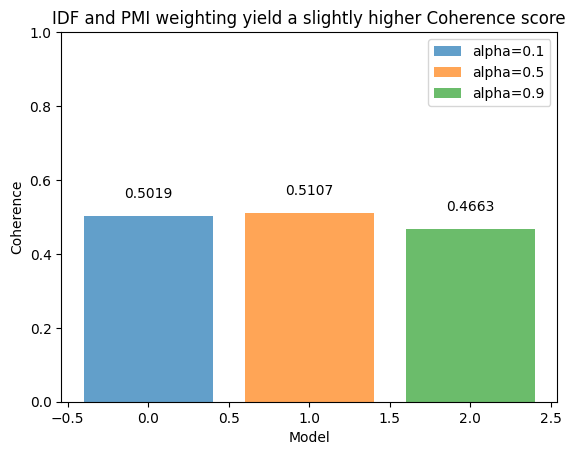

In [56]:
df_coherence = pd.DataFrame(coherence_scores).T
df_coherence.columns = model_names
df_coherence= df_coherence.melt(var_name="model").round(4)
df_coherence.reset_index(inplace=True)

fig, ax = plt.subplots()

# Create the bar plot
for key, grp in df_coherence.groupby('model'):
    ax.bar(grp['index'], grp['value'], label=key, alpha=0.7)

# Add text labels above the bars
for i, row in df_coherence.iterrows():
    ax.text(row['index'], row['value'] + 0.05, str(row['value']), ha='center')

# Setting the labels and title
ax.set_xlabel('Model')
ax.set_ylabel('Coherence')
ax.set_title('IDF and PMI weighting yield a slightly higher Coherence score')
ax.set_ylim(0, 1)  # Setting y limits to match your ggplot code

# Add a legend
ax.legend()

# Show the plot
plt.show()

There are a lot of parameters to tune, and it could take some time to tune them all.
Ive tuned some of the HDP parameters (alpha, gamma, rm_top), and the best number of topics is between 30-40.

## Archive

In [ ]:
import tomotopy as tp
import pandas as pd

from datetime import datetime

def compute_perplexity(lda_model):
    """ Computes the perplexity of the LDA model """
    return lda_model.perplexity

def js_divergence(model):
    """ Computes the Jensen-Shannon divergence between topic distributions """
    topic_probs = [model.get_topic_word_dist(k) for k in range(model.k)]
    avg_probs = np.mean(topic_probs, axis=0)
    js_divs = []
    for probs in topic_probs:
        js_div = distance.jensenshannon(probs, avg_probs, base=2)
        js_divs.append(js_div)
    return np.mean(js_divs)


corpus_tp = tp.utils.Corpus()
for text in texts:
    corpus_tp.add_doc(words=text)
corpus_tp_lem = tp.utils.Corpus()
for text in texts_lem:
    corpus_tp_lem.add_doc(words=text)
    
def train_multiple_lda_tomotopy(topic_nums:range, corpus, coherence_met = "c_v"):
    results = []
    models = []
    for k in topic_nums:
        model = tp.LDAModel(k=k, alpha=1.0/k, eta=1.0/k, min_cf=0, corpus=corpus, seed=42)
        model.train(200)  # number of iterations, adjust as necessary
        models.append(model)
        perplexity = compute_perplexity(model)
        js_div = js_divergence(model)
        ch =  tp.coherence.Coherence(model, coherence=coherence_met)
        coherence = ch.get_score()
        print(f"{datetime.now()} - k={k}, perplexity={perplexity}, js_div={js_div}, coherence={coherence}")
        results.append({"num_topics": k, "perplexity": perplexity, "coherence": coherence, "js_div": js_div})
    results = pd.DataFrame(results).set_index("num_topics")
    return results
    
def train_multiple_lda_tomotopy(topic_nums:range, corpus,test_corpus, coherence_met = "c_v"):
    results = []
    models = []
    for k in topic_nums:
        model = tp.LDAModel(k=k, alpha=1.0/k, eta=1.0/k, min_cf=0, corpus=corpus, seed=42)
        model.train(200)  # number of iterations, adjust as necessary
        models.append(model)
        perplexity = compute_perplexity(model)
        js_div = js_divergence(model)
        ch =  tp.coherence.Coherence(model, coherence=coherence_met)
        coherence = ch.get_score()
        print(f"{datetime.now()} - k={k}, perplexity={perplexity}, js_div={js_div}, coherence={coherence}")
        results.append({"num_topics": k, "perplexity": perplexity, "coherence": coherence, "js_div": js_div})
    results = pd.DataFrame(results).set_index("num_topics")
    return results


In [ ]:
from octis.evaluation_metrics.diversity_metrics import TopicDiversity, LogOddsRatio,KLDivergence
from octis.models.LDA import LDA
from octis.dataset.dataset import Dataset
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_by_book,test_size=0.05, random_state=42)
train_texts, train_id2word, train_corpus = generate_componentes_for_gensim(train, "processed_text")
test_texts, test_id2word, test_corpus = generate_componentes_for_gensim(test, "processed_text")

tsv_mapping = {"train": train_texts, "test": test_texts}
vocab = set()
with open(f'data/OCTIS/corpus.tsv', 'w') as file:
    for k, v in tsv_mapping.items():
        for document in v:
            file.write(f'{document}\t{k}\n')
            for word in document:
                vocab.add(word)

with open(f'data/OCTIS/vocab.txt', 'w') as file:
    
    for word in list(vocab):
        file.write(f'{word}\n')
         
dataset = Dataset()
dataset.load_custom_dataset_from_folder("data/OCTIS")
rng = list(range(2,30,1))+list(range(30,100,5))+list(range(100,200,20))
len(rng)
def train_multiple_lda_gensim(topic_nums:range, corpus, id2word, texts,test_corpus, coherence_met = "c_v"):
    results = []
    # topic_nums = range(2, 100, 2)
    models = []
    for k in topic_nums:
        model = LdaModel(corpus=corpus, id2word=id2word, num_topics=k, random_state=42,alpha=0.2,eta=0.2)
        models.append(model)
        perplexity = compute_perplexity_gensim(model, test_corpus)
        js_div = js_divergence_gensim([model.get_topic_terms(topicid) for topicid in range(model.num_topics)])
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence=coherence_met)
        coherence = coherencemodel.get_coherence()
        print(f"{datetime.now()} - {k=}, {perplexity=}, {js_div=}, {coherence=}")
        results.append({"num_topics":k,"perplexity":perplexity, "coherence":coherence, "js_div":js_div})
    results = pd.DataFrame(results).set_index("num_topics")
    return results
coherence_metrics = ['u_mass', 'c_v', 'c_uci', 'c_npmi']
results = []


for k in rng:
    iter_result = {}
    model = LDA(num_topics=k, random_state=42,alpha=0.2,eta=0.2)  # Create model
    model_output = model.train_model(dataset) # Train the model
    
    metric = TopicDiversity(topk=10) # Initialize metric
    topic_diversity_score = metric.score(model_output)

    metric = LogOddsRatio() # Initialize metric
    log_odds_ratio = metric.score(model_output)
    
    metric = KLDivergence() # Initialize metric
    kl_div = metric.score(model_output)
    for met in coherence_metrics:
        tmp_co = Coherence(texts=dataset.get_corpus(), topk=10, measure=met)
        iter_result.update({f"Coherence_{met}":tmp_co.score(model_output)})
    iter_result.update({"num_topics":k,"topic_diversity_score":topic_diversity_score,"log_odds_ratio":log_odds_ratio, "kl_div":kl_div})
    print(f"{datetime.now() } - {k} topics {iter_result}")
    results.append(iter_result)
final_results =  pd.DataFrame(results)


    

In [ ]:

# from gensim.models import CoherenceModel
# import pandas as pd
# from gensim.models import LdaModel
# from scipy.spatial import distance
# from gensim import corpora
# from datetime import datetime

# def compute_perplexity_gensim(lda_model, test_corpus):
#     """ Computes the perplexity of the LDA model on the test corpus """
#     perplexity = lda_model.log_perplexity(test_corpus)
#     return np.exp2(perplexity)

# def js_divergence_gensim(topic_probs):
#     """ Computes the Jensen-Shannon divergence between topic distributions """
#     avg_probs = np.mean(topic_probs, axis=0)
#     js_divs = []
#     for probs in topic_probs:
#         js_div = distance.jensenshannon(probs, avg_probs, base=2)
#         js_divs.append(js_div)
#     return np.mean(js_divs)




# def train_multiple_lda_gensim(topic_nums:range, corpus, id2word, texts, coherence_met = "c_v"):
#     results = []
#     # topic_nums = range(2, 100, 2)
#     models = []
#     for k in topic_nums:
#         model = LdaModel(corpus=corpus, id2word=id2word, num_topics=k, random_state=42,alpha=1.0/k,eta=1.0/k)
#         models.append(model)
#         perplexity = compute_perplexity_gensim(model, corpus)
#         js_div = js_divergence_gensim([model.get_topic_terms(topicid) for topicid in range(model.num_topics)])
#         coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence=coherence_met)
#         coherence = coherencemodel.get_coherence()
#         print(f"{datetime.now()} - {k=}, {perplexity=}, {js_div=}, {coherence=}")
#         results.append({"num_topics":k,"perplexity":perplexity, "coherence":coherence, "js_div":js_div})
#     results = pd.DataFrame(results).set_index("num_topics")
#     return results
    

# def plot_lda_metrics(df, ax, title=None, show_legend=True):
#     # Normalize data (Min-Max scaling)
#     df_normalized = (df - df.min()) / (df.max() - df.min())
    
#     # Plotting on the provided axis
#     for column in df_normalized.columns:
#         ax.plot(df_normalized.index, df_normalized[column], label=column)
#     if title:
#         ax.set_title(title)
#     ax.set_xlabel('Number of topics')
#     ax.set_ylabel('Normalized Values')
#     if show_legend:
#         ax.legend()



In [7]:

regular_gensim_ldas = train_multiple_lda_gensim(range(2, 100, 2), corpus,id2word,texts)
lemmatized_gensim_ldas = train_multiple_lda_gensim(range(2, 100, 2), corpus_lem,id2word_lem,texts_lem)
regular_tp_ldas = train_multiple_lda_tomotopy(range(2, 100, 2), corpus_tp)
lemmatized_tp_ldas = train_multiple_lda_tomotopy(range(2, 100, 2), corpus_tp_lem)

2024-05-04 22:21:24.062554 - k=2, perplexity=0.0016522242182716409, js_div=0.2571434142758413, coherence=0.26541081688609436
2024-05-04 22:21:37.491790 - k=4, perplexity=0.0013927929803690998, js_div=0.2862321852449828, coherence=0.29469018218625426
2024-05-04 22:21:50.178808 - k=6, perplexity=0.0011776526061738613, js_div=0.28342177762018944, coherence=0.31625352339591156
2024-05-04 22:22:03.112236 - k=8, perplexity=0.0010041629078579055, js_div=0.26827908839019443, coherence=0.3255998045549248
2024-05-04 22:22:19.305804 - k=10, perplexity=0.0008223426564754003, js_div=0.29108072893756776, coherence=0.32089534144767506
2024-05-04 22:22:33.364696 - k=12, perplexity=0.0006715706919290305, js_div=0.3095787981194969, coherence=0.329281979859145
2024-05-04 22:22:47.091920 - k=14, perplexity=0.0005699625000976146, js_div=0.28235455730662723, coherence=0.3230623019327022
2024-05-04 22:23:01.108873 - k=16, perplexity=0.00047881144602764976, js_div=0.30359631160568085, coherence=0.309095214591

/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_67079/212717407.py:105: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(200)  # number of iterations, adjust as necessary


2024-05-04 22:46:21.652033 - k=2, perplexity=9598.23051079754, js_div=0.31491047382587467, coherence=0.4575265266001225
2024-05-04 22:46:22.126970 - k=4, perplexity=8796.321290615335, js_div=0.45661629858242203, coherence=0.7546867460012435
2024-05-04 22:46:22.561290 - k=6, perplexity=8440.855371754056, js_div=0.5179911339183098, coherence=0.638783005795752
2024-05-04 22:46:22.991375 - k=8, perplexity=8460.516100174606, js_div=0.5561289660325814, coherence=0.7794599218294025
2024-05-04 22:46:23.541925 - k=10, perplexity=8024.65878603832, js_div=0.5845268658462996, coherence=0.7866360206902027
2024-05-04 22:46:24.177375 - k=12, perplexity=8002.132395428012, js_div=0.6013300794584556, coherence=0.7794612237562736
2024-05-04 22:46:24.836288 - k=14, perplexity=8240.193764401532, js_div=0.6198718590343668, coherence=0.7783879131610905
2024-05-04 22:46:25.541837 - k=16, perplexity=7968.758110530411, js_div=0.6314357079036285, coherence=0.7390331887640059
2024-05-04 22:46:26.464904 - k=18, pe

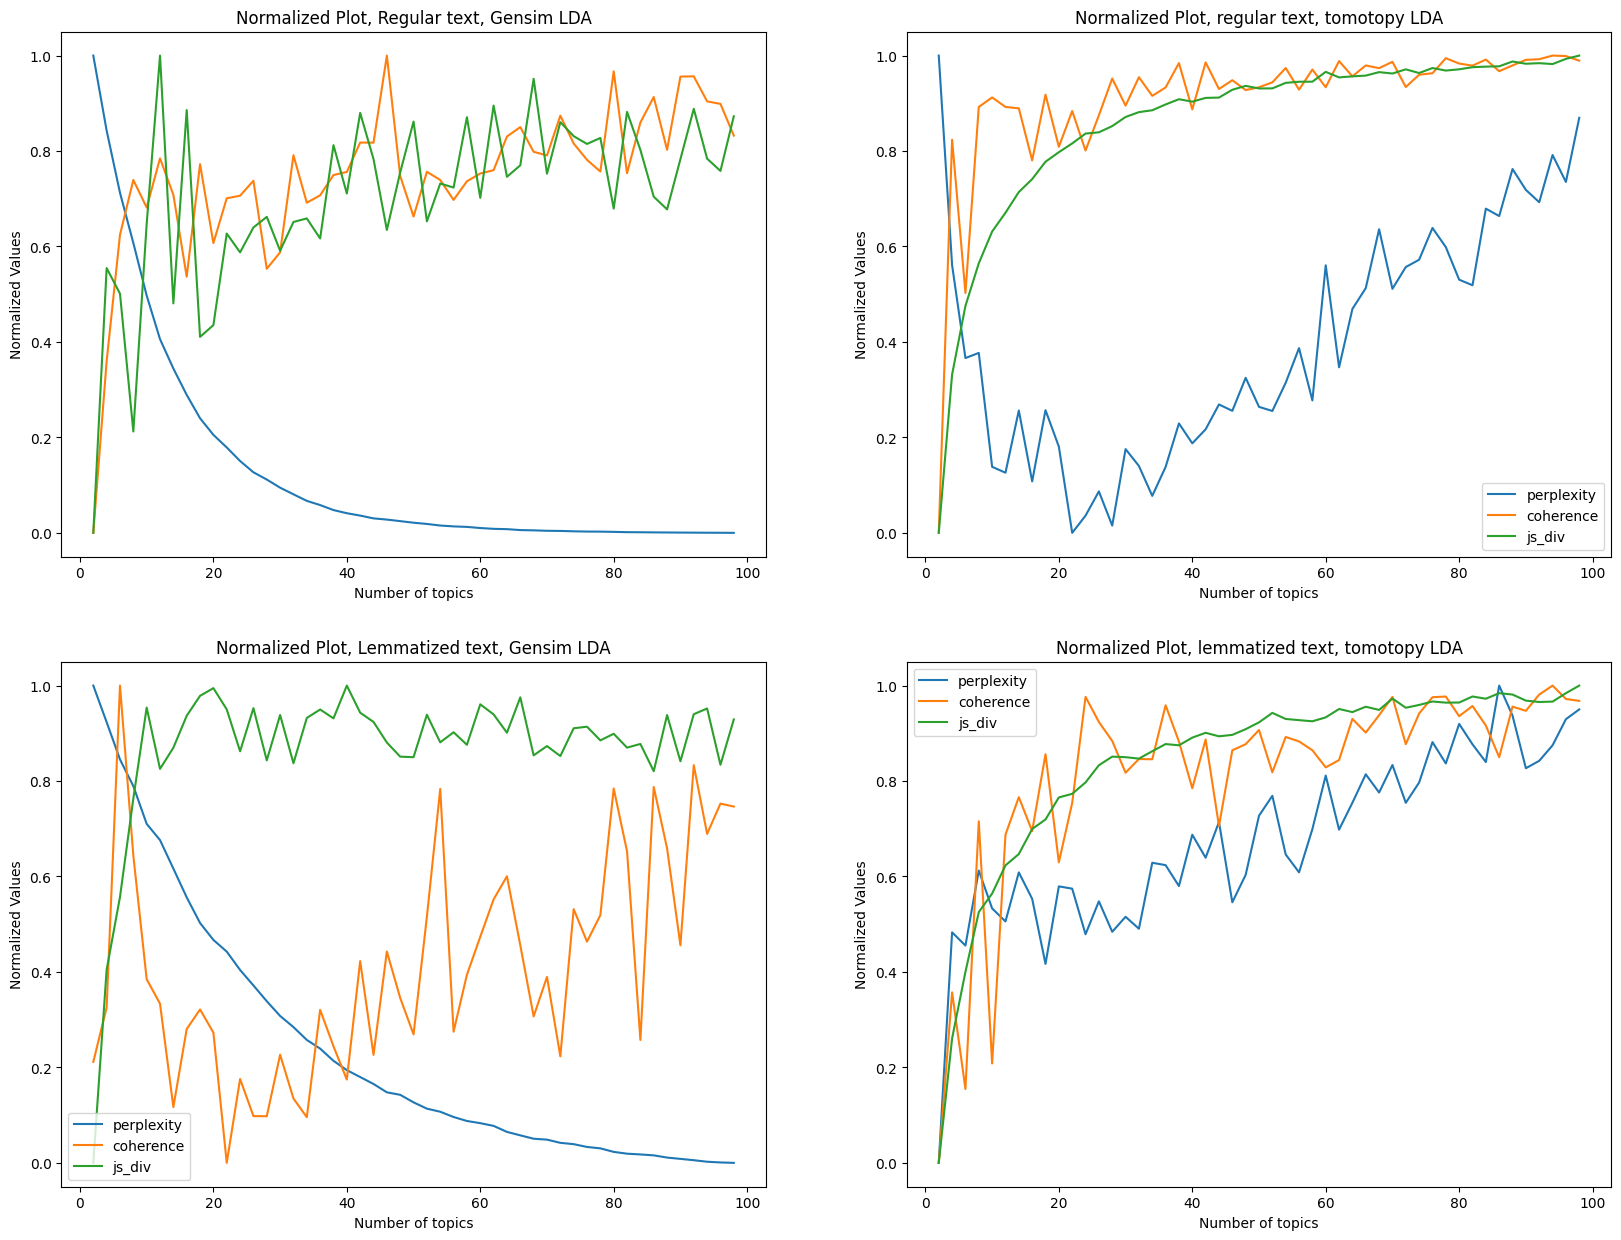

In [8]:
# Usage:
fig, ax = plt.subplots(2,2,figsize=(20, 15))  # Create a figure and an axes.
plot_lda_metrics(regular_gensim_ldas, ax[0,0], "Normalized Plot, Regular text, Gensim LDA", show_legend=False)
plot_lda_metrics(regular_tp_ldas,ax[0,1],"Normalized Plot, regular text, tomotopy LDA")
plot_lda_metrics(lemmatized_gensim_ldas, ax[1,0], "Normalized Plot, Lemmatized text, Gensim LDA")

plot_lda_metrics(lemmatized_tp_ldas,ax[1,1],"Normalized Plot, lemmatized text, tomotopy LDA")
plt.show()

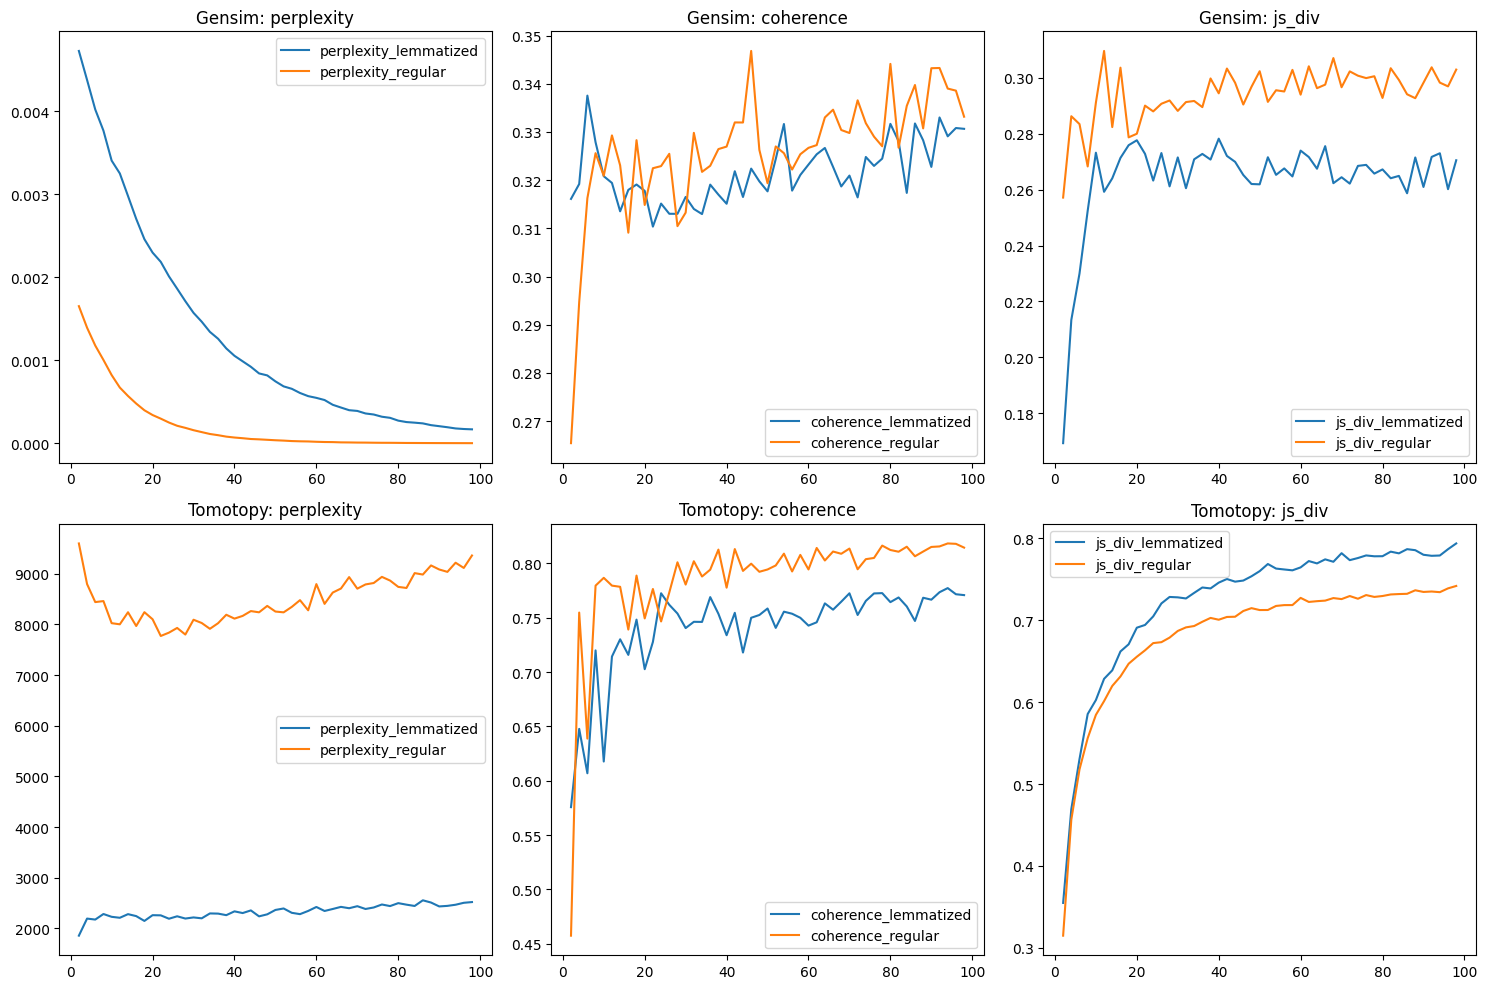

In [9]:
import matplotlib.pyplot as plt

# Data preparation
gensim_comparison = lemmatized_gensim_ldas.join(regular_gensim_ldas, lsuffix="_lemmatized", rsuffix="_regular")
tp_comparison = lemmatized_tp_ldas.join(regular_tp_ldas, lsuffix="_lemmatized", rsuffix="_regular")

# Metrics to compare
metrics = ["perplexity", "coherence", "js_div"]

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))  # Adjust the figure size as necessary

# Loop through the metrics and plot
for i, metric in enumerate(metrics):
    # Gensim comparison plots
    cols_gensim = [f"{metric}_lemmatized", f"{metric}_regular"]
    axes[0, i].plot(gensim_comparison.index, gensim_comparison[cols_gensim[0]], label=cols_gensim[0])
    axes[0, i].plot(gensim_comparison.index, gensim_comparison[cols_gensim[1]], label=cols_gensim[1])
    axes[0, i].set_title(f"Gensim: {metric}")
    axes[0, i].legend()

    # Topic Modeling Toolbox comparison plots
    cols_tp = [f"{metric}_lemmatized", f"{metric}_regular"]
    axes[1, i].plot(tp_comparison.index, tp_comparison[cols_tp[0]], label=cols_tp[0])
    axes[1, i].plot(tp_comparison.index, tp_comparison[cols_tp[1]], label=cols_tp[1])
    axes[1, i].set_title(f"Tomotopy: {metric}")
    axes[1, i].legend()

# Adjust layout
plt.tight_layout()
plt.show()


In [8]:
from collections import Counter
def get_top_n_words(texts,n):
    tt = Counter([
        x
        for xs in texts
        for x in xs
    ])
    return [i[0] for i in tt.most_common(n)]
def remove_words_from_text(texts, most_common_words):
    new_texts = []
    for book in texts:
        tmp_book = []
        for word in book:
            if word not in  most_common_words:
                tmp_book.append(word)
        new_texts.append(tmp_book)
    return new_texts
                

In [60]:
from gensim.models import CoherenceModel

n_topics = 25
k = n_topics
texts = [
    [word for word in str(doc).split(" ")]
    for doc in df_by_book['processed_text']
]
most_common_words = get_top_n_words(texts, 3)
texts = remove_words_from_text(texts, most_common_words)
print(f"removed {str(most_common_words)} from text")
id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]



texts_lem = [
    [word for word in str(doc).split(" ")]
    for doc in df_by_book['lemmatized_text']
]
most_common_words = get_top_n_words(texts_lem, 3)
texts_lem = remove_words_from_text(texts_lem, most_common_words)
print(f"removed {str(most_common_words)} from texts_lem")
id2word_lem = corpora.Dictionary(texts_lem)
corpus_lem = [id2word_lem.doc2bow(text) for text in texts_lem]

model = LdaModel(corpus=corpus, id2word=id2word, num_topics=n_topics, random_state=42,alpha=1.0/n_topics,eta=1.0/n_topics)
model_lem = LdaModel(corpus=corpus_lem, id2word=id2word_lem, num_topics=n_topics, random_state=42,alpha=1.0/n_topics,eta=1.0/n_topics)


corpus_tp = tp.utils.Corpus()
for text in texts:
    corpus_tp.add_doc(words=text)
corpus_tp_lem = tp.utils.Corpus()
for text in texts_lem:
    corpus_tp_lem.add_doc(words=text)
# model_tp = tp.LDAModel(k=k, alpha=1.0/k, eta=1.0/k, min_cf=0, corpus=corpus_tp, seed=42)
# model_lem_tp = tp.LDAModel(k=k, alpha=1.0/k, eta=1.0/k, min_cf=0, corpus=corpus_tp_lem, seed=42)
# coherencemodel = CoherenceModel(model=model, texts=texts_lem, dictionary=id2word_lem, coherence='c_v')
# print(coherencemodel.get_coherence())
# print(-np.exp(model.log_perplexity(corpus_lem)))

removed ['כול', 'לוא', 'איש'] from text
removed ['כול', 'לוא', 'יום'] from texts_lem


In [ ]:

# def plot_lda_metrics(df, ax, title=None, show_legend=True):
#     # Normalize data (Min-Max scaling)
#     df_normalized = (df - df.min()) / (df.max() - df.min())
    
#     # Plotting on the provided axis
#     for column in df_normalized.columns:
#         ax.plot(df_normalized.index, df_normalized[column], label=column)
#     if title:
#         ax.set_title(title)
#     ax.set_xlabel('Number of topics')
#     ax.set_ylabel('Normalized Values')
#     if show_legend:
#         ax.legend()
# fig, ax = plt.subplots(1,2,figsize=(14,10))

# plot_lda_metrics(tp_simulation_results_lem[["Coherence_c_v", "Coherence_u_mass", "perplexity", "js_div"]],ax[0])
# ax[0].axvline(x=23, color='r', linestyle='--', label='Optional optimal n_topics')
# ax[0].set_title("Lemmatized texts, results by metrics (normalized)")

# plot_lda_metrics(tp_simulation_results[["Coherence_c_v", "Coherence_u_mass", "perplexity", "js_div"]],ax[1])
# ax[1].axvline(x=23, color='r', linestyle='--', label='Optional optimal n_topics')
# ax[1].set_title("Regular texts, results by metrics (normalized)")

In [ ]:
import seaborn as sns
# import matplotlib.colors as mcolors
# cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
# topics_to_show = len(biggest_topics)
# fig, axes = plt.subplots(topics_to_show//2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

# for i, ax in tqdm(enumerate(axes.flatten())):
#     df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == biggest_topics[i], :]
#     doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
#     ax.hist(doc_lens, bins = 1000, color=cols[i])
#     ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
#     sns.kdeplot(doc_lens, color="black", fill=False, ax=ax.twinx())
#     ax.set(xlim=(0, 1000), xlabel='Document Word Count')
#     ax.set_ylabel('Number of Documents', color=cols[i])
#     ax.set_title('Topic: '+str(biggest_topics[i]), fontdict=dict(size=16, color=cols[i]))

# fig.tight_layout()
# fig.subplots_adjust(top=0.90)
# plt.xticks(np.linspace(0,1000,9))
# fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
# plt.show()